# Exploration of the Power Usage dataset from 2016 to 2020 Houston TX.

### Import libraries, dataset, and perform basic data review and adjustment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy.special import inv_boxcox


In [2]:
df = pd.read_csv('power_usage_2016_to_2020.csv')

In [3]:
df.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [4]:
df.describe()

,Value (kWh),day_of_week
count,35952.000000,35952.000000
mean,0.891631,2.997330
std,0.908133,1.999024
min,0.064000,0.000000
25%,0.323750,1.000000
50%,0.501000,3.000000
75%,1.072000,5.000000
max,6.446000,6.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StartDate    35952 non-null  object 
 1   Value (kWh)  35952 non-null  float64
 2   day_of_week  35952 non-null  int64  
 3   notes        35952 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


In [6]:
df['StartDate'] = pd.to_datetime(df['StartDate'])
df['notes'] = df['notes'].astype(str)
df['year'] = df['StartDate'].dt.year
df['month'] = df['StartDate'].dt.month

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   StartDate    35952 non-null  datetime64[ns]
 1   Value (kWh)  35952 non-null  float64       
 2   day_of_week  35952 non-null  int64         
 3   notes        35952 non-null  object        
 4   year         35952 non-null  int32         
 5   month        35952 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(1), object(1)
memory usage: 1.4+ MB


In [8]:
df.head()

,StartDate,Value (kWh),day_of_week,notes,year,month
0,2016-01-06 00:00:00,1.057,2,weekday,2016,1
1,2016-01-06 01:00:00,1.171,2,weekday,2016,1
2,2016-01-06 02:00:00,0.560,2,weekday,2016,1
3,2016-01-06 03:00:00,0.828,2,weekday,2016,1
4,2016-01-06 04:00:00,0.932,2,weekday,2016,1


In [9]:
df.isna().sum()

StartDate      0
Value (kWh)    0
day_of_week    0
notes          0
year           0
month          0
dtype: int64

In [10]:
df.head()

,StartDate,Value (kWh),day_of_week,notes,year,month
0,2016-01-06 00:00:00,1.057,2,weekday,2016,1
1,2016-01-06 01:00:00,1.171,2,weekday,2016,1
2,2016-01-06 02:00:00,0.560,2,weekday,2016,1
3,2016-01-06 03:00:00,0.828,2,weekday,2016,1
4,2016-01-06 04:00:00,0.932,2,weekday,2016,1


<Axes: xlabel='StartDate'>

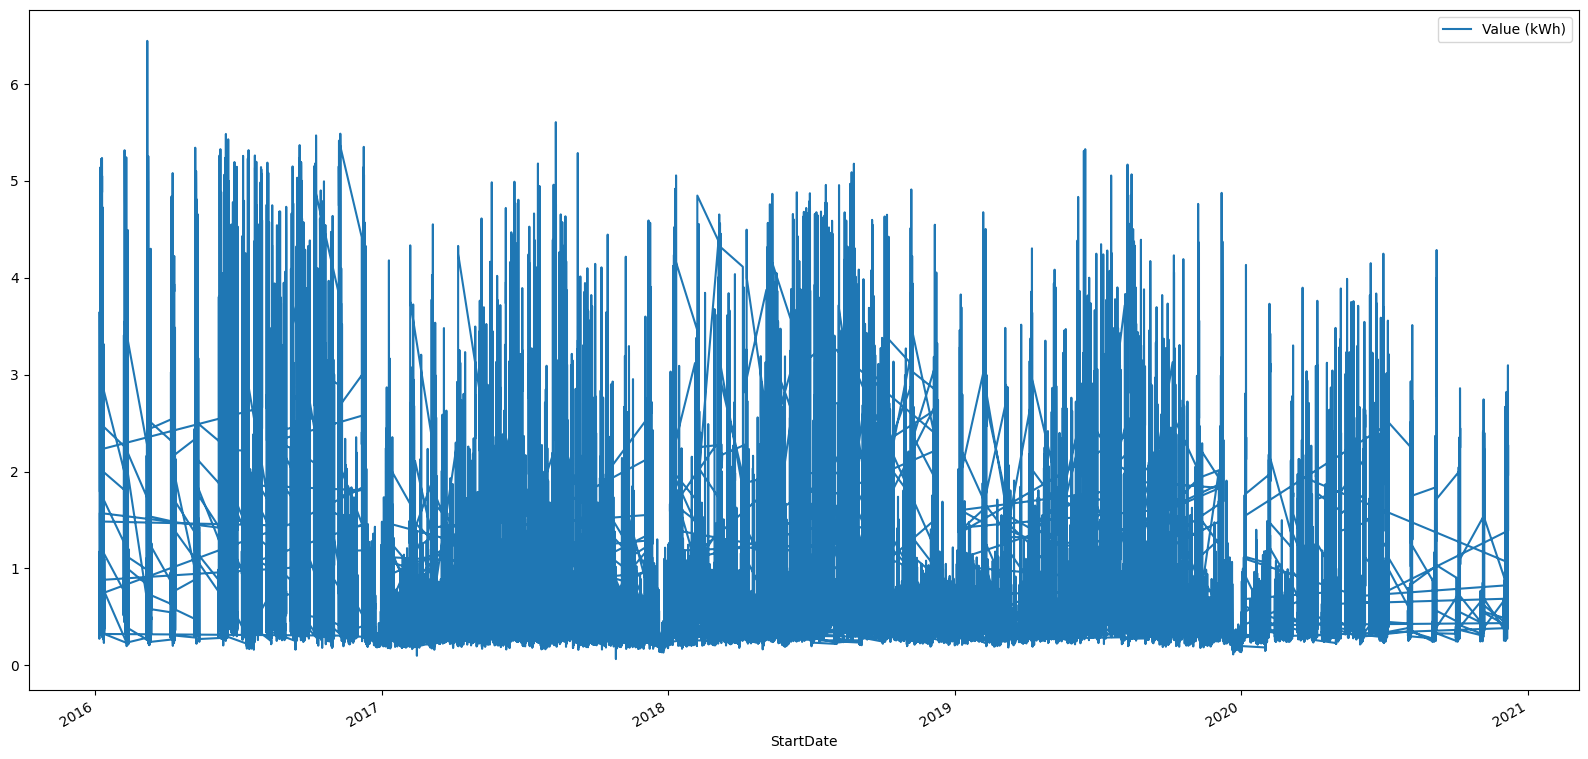

In [11]:
df.plot.line(x='StartDate', y='Value (kWh)', figsize=(20, 10))

### Data appears to have odd anomalies as seen by the drastic line changes. This could indicate corrupted data, missing data, or unordered data

In [12]:
df = df.sort_values(by='StartDate',ascending=True)

<Axes: xlabel='StartDate'>

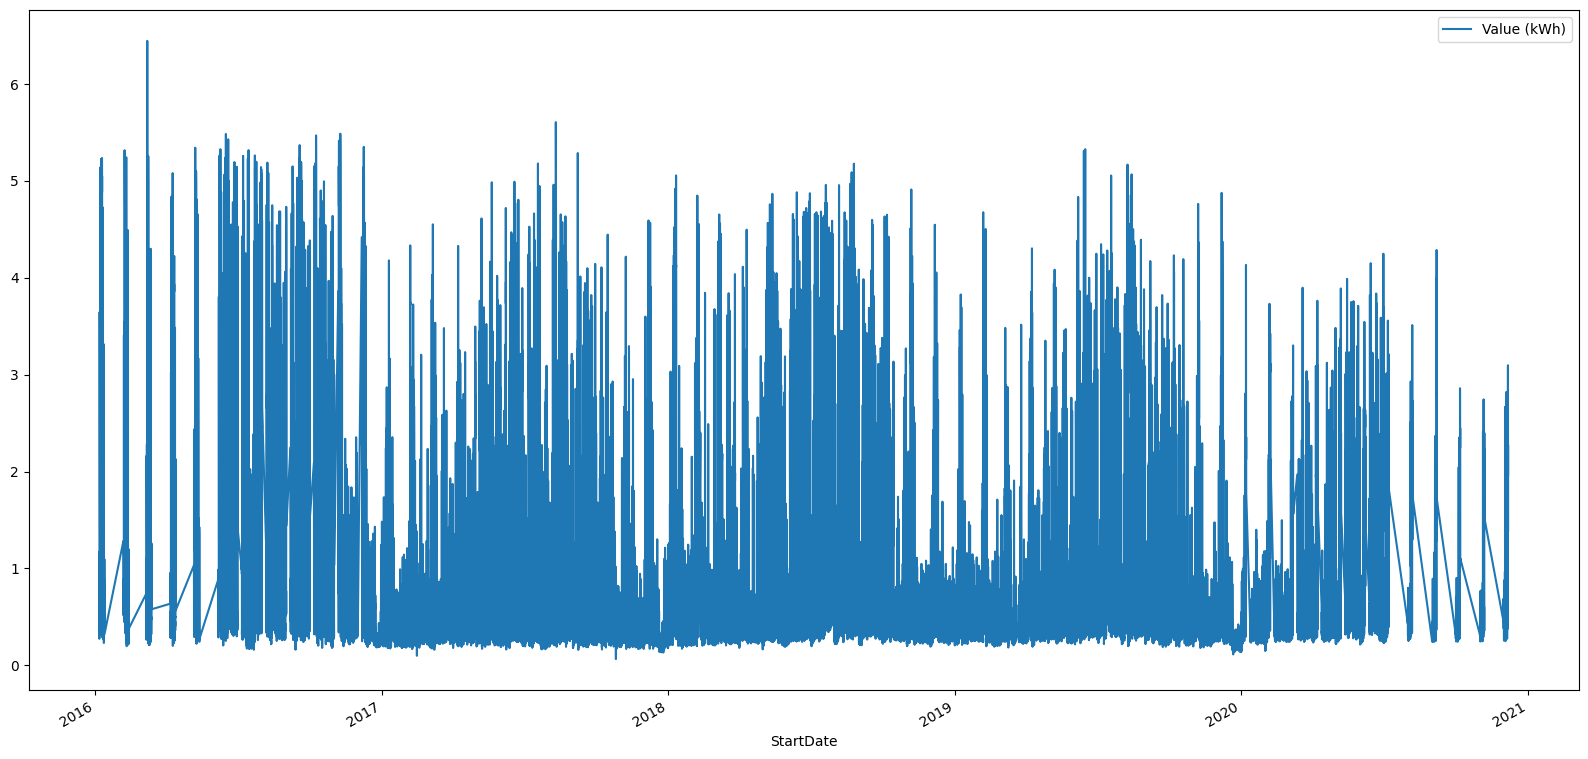

In [13]:
df.plot.line(x='StartDate', y='Value (kWh)', figsize=(20, 10))

### Basic sorting of the dates appeared to have help, but uncovered odd data in 2016 and 2020. Further review of the 2016 will be done in order to get a better understanding of the data.

<Axes: xlabel='StartDate'>

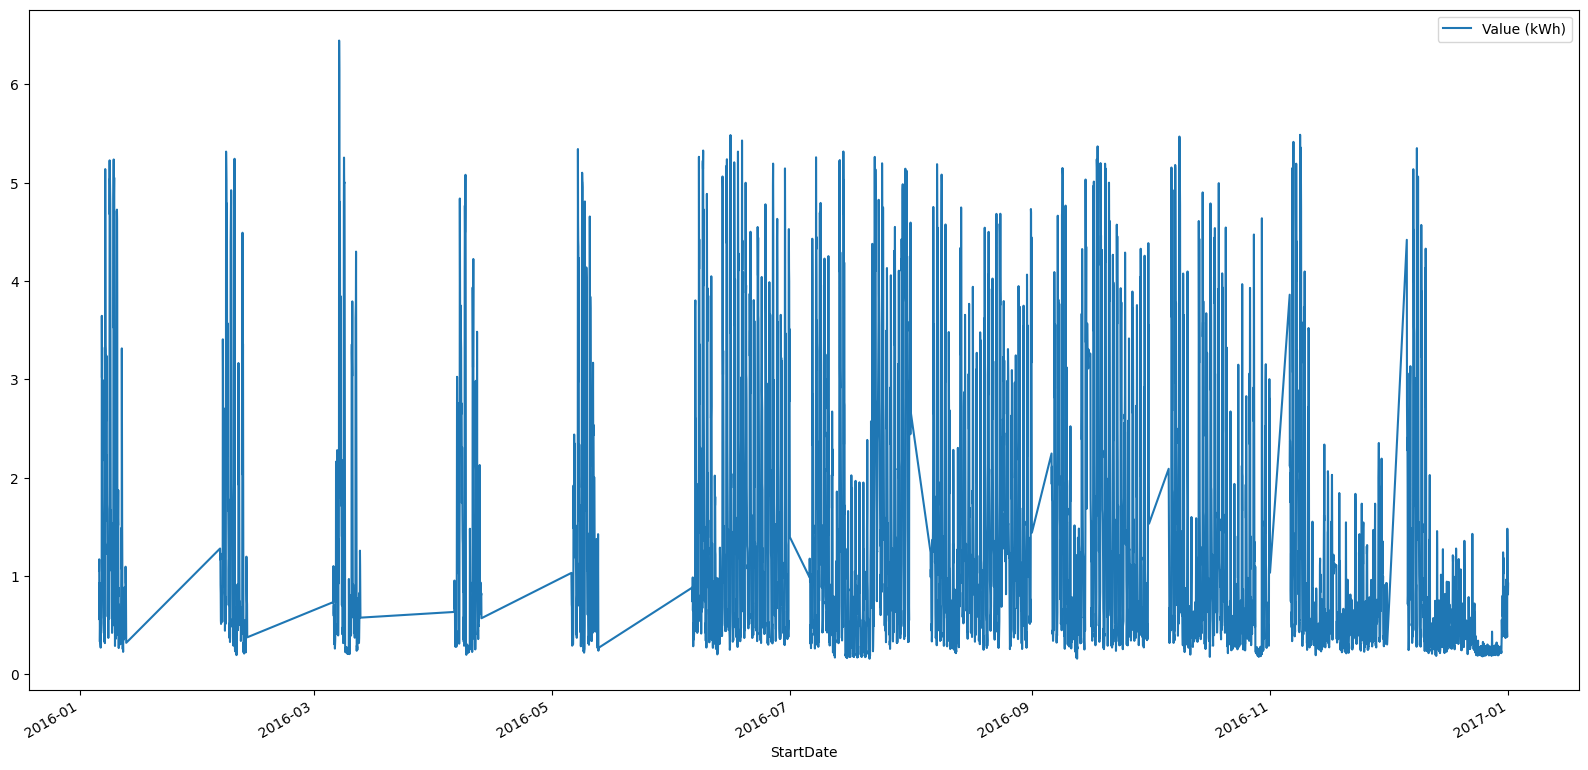

In [14]:
df2016 = df[df['year'] == 2016]
df2016.plot.line(x='StartDate', y='Value (kWh)', figsize=(20, 10))

In [15]:
df2016.groupby('month').agg('count')

,StartDate,Value (kWh),day_of_week,notes,year
month,,,,,
1,168,168,168,168,168
2,168,168,168,168,168
3,168,168,168,168,168
4,168,168,168,168,168
5,168,168,168,168,168
6,600,600,600,600,600
7,624,624,624,624,624
8,624,624,624,624,624
9,600,600,600,600,600


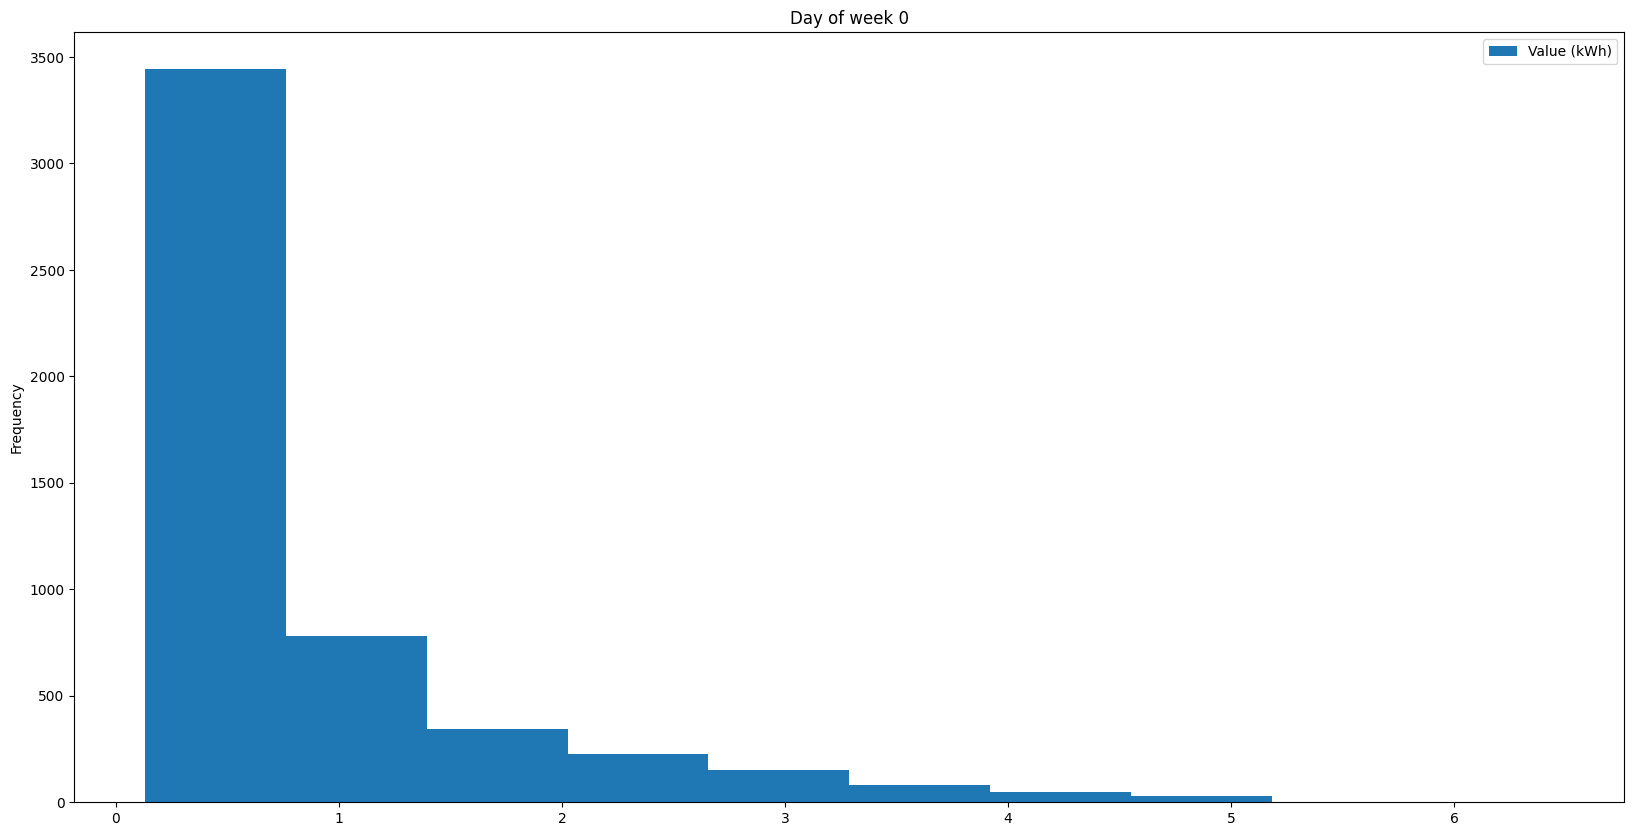

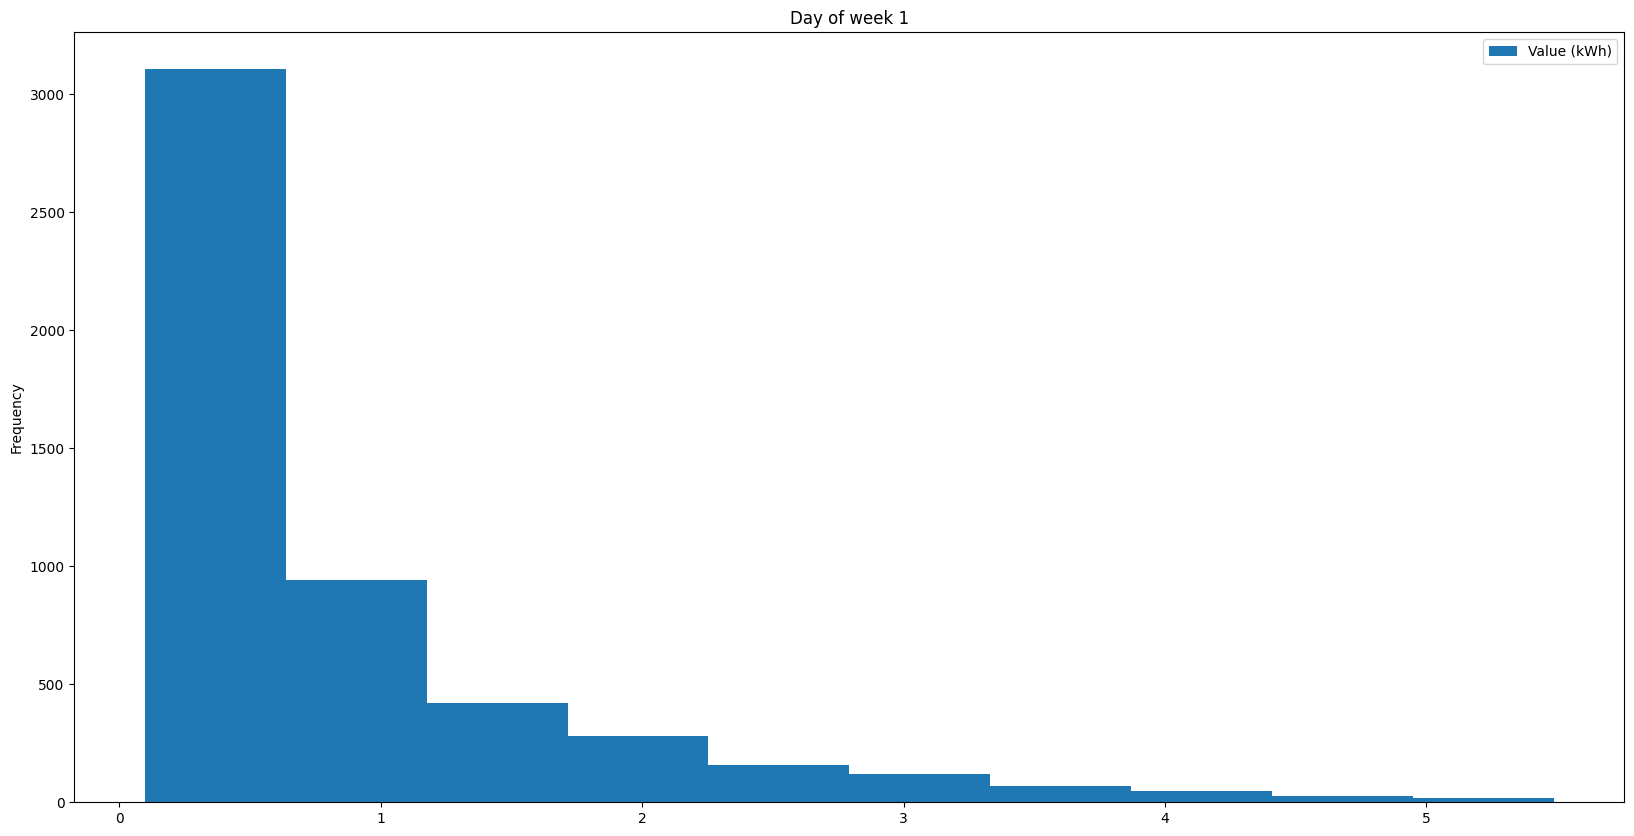

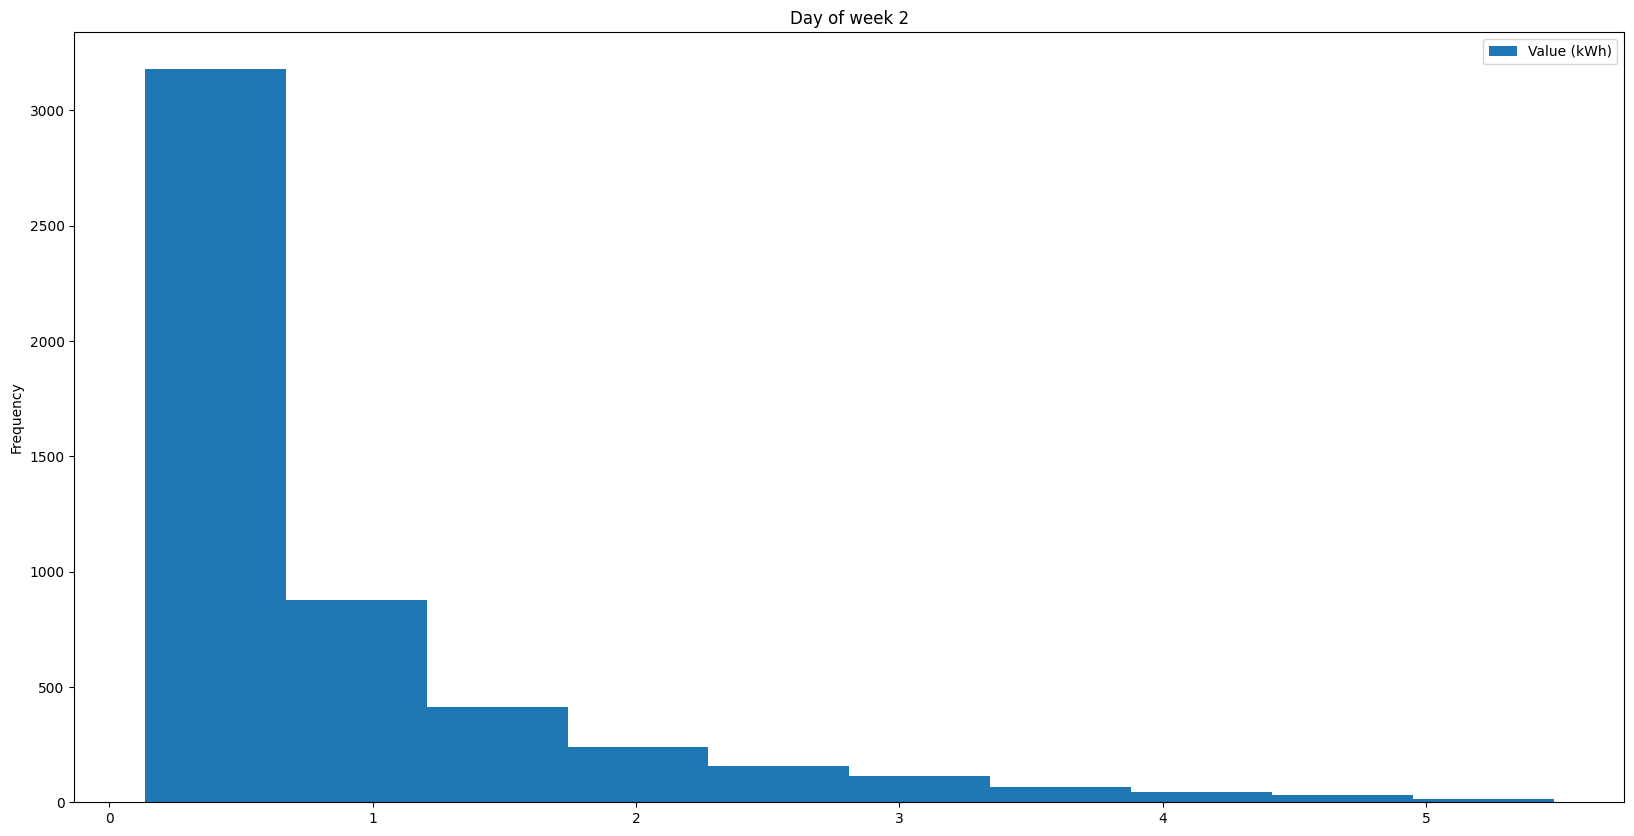

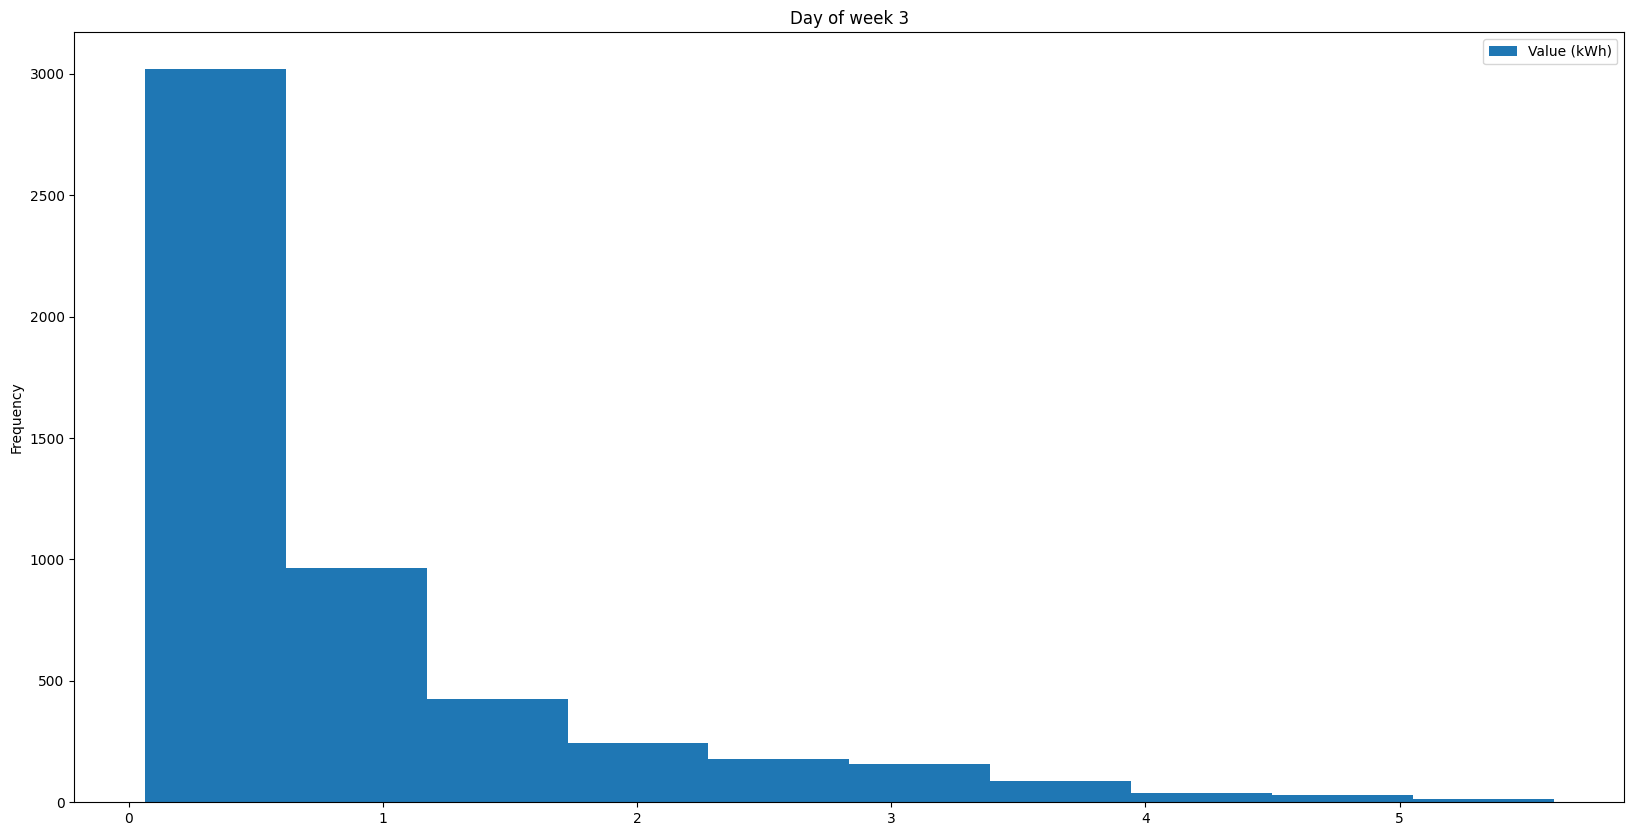

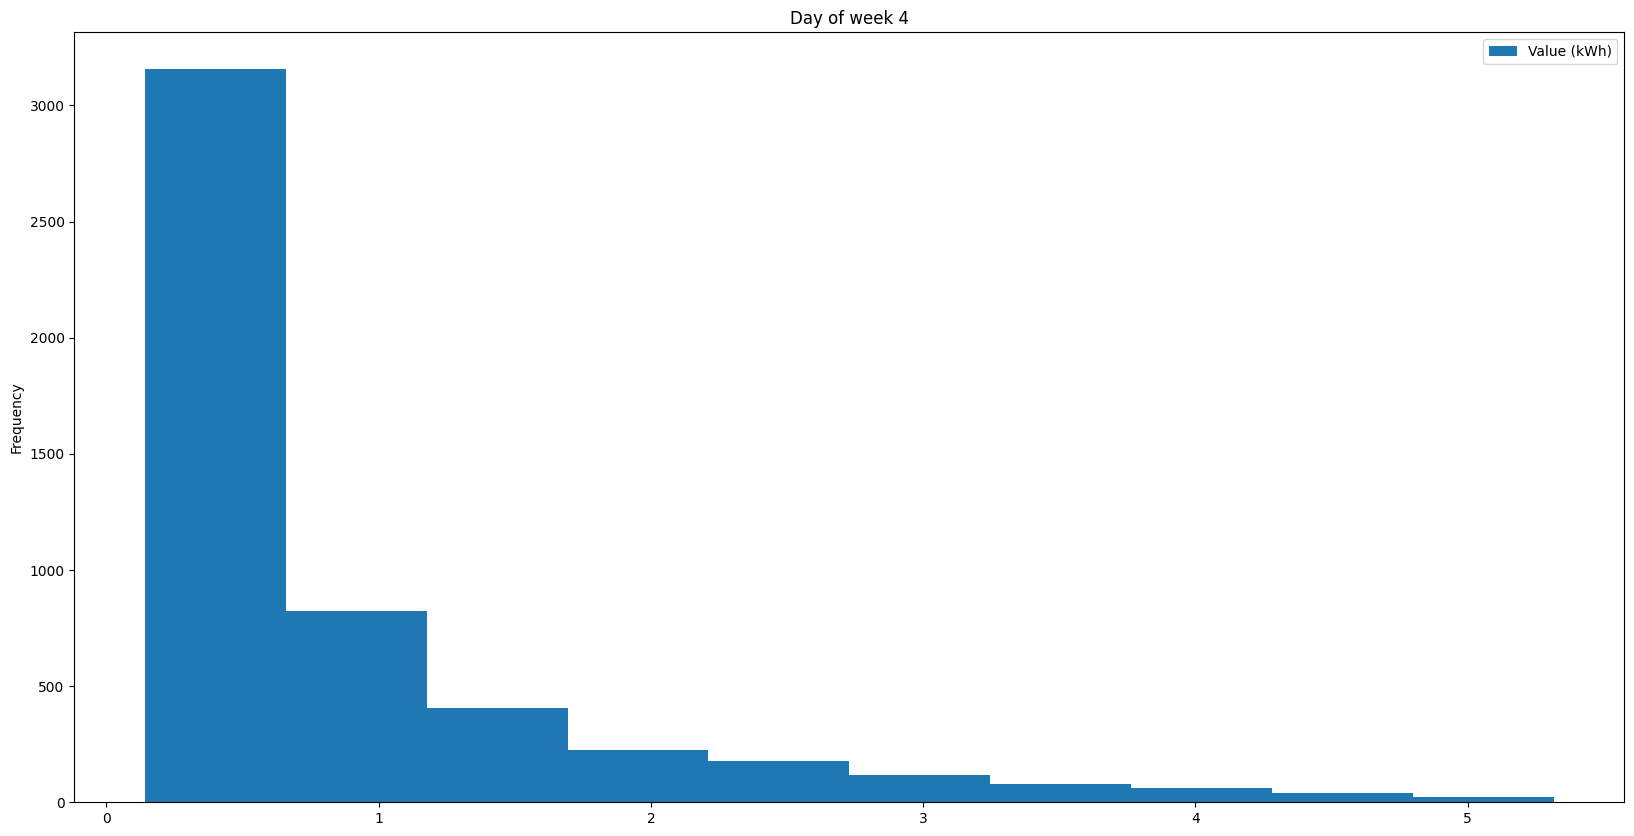

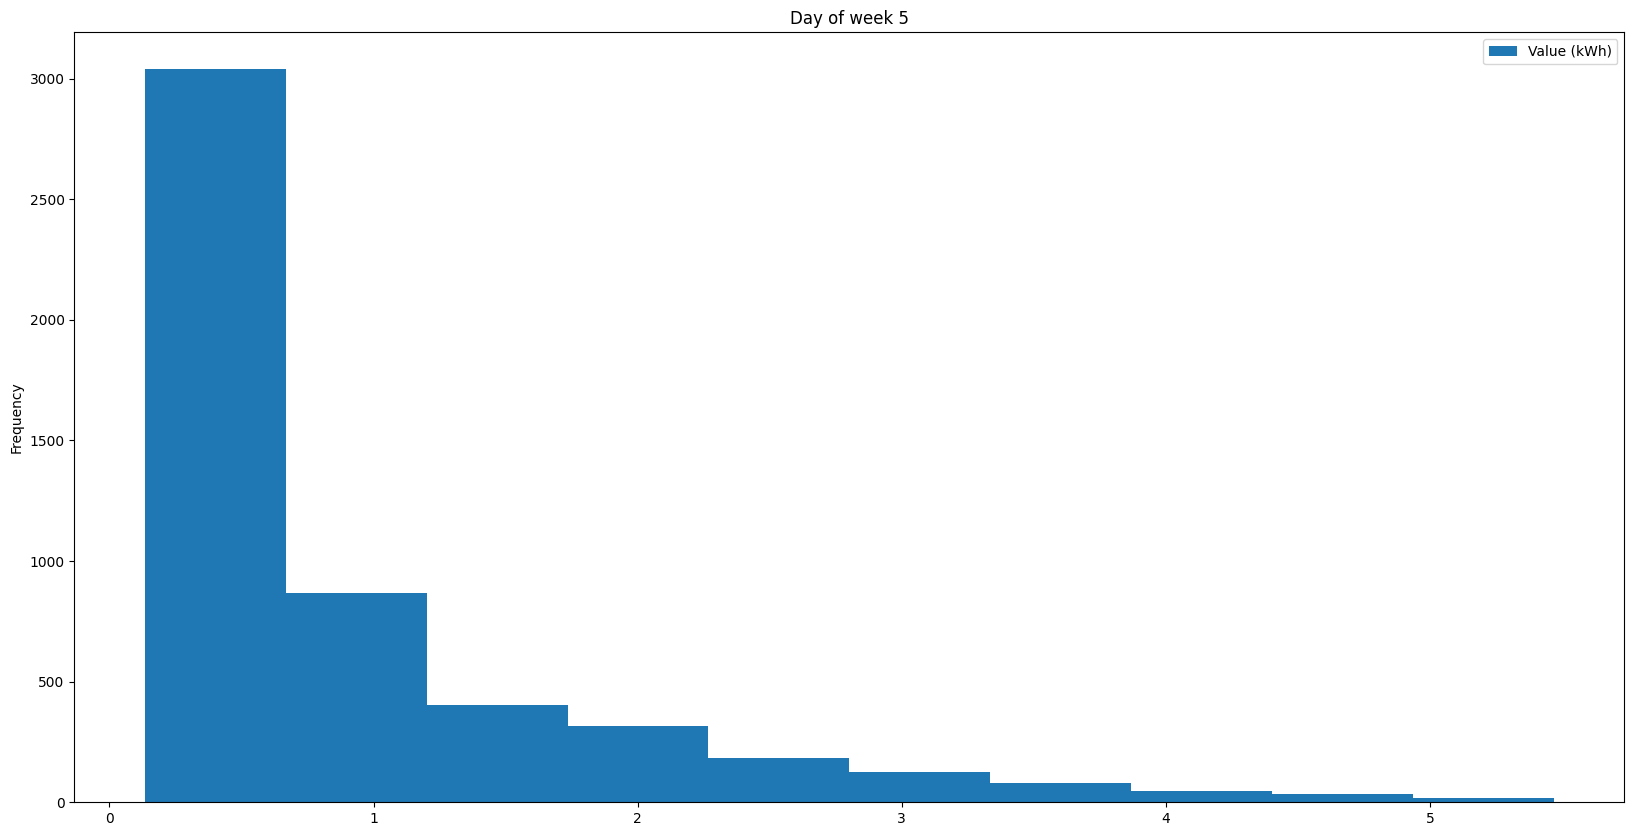

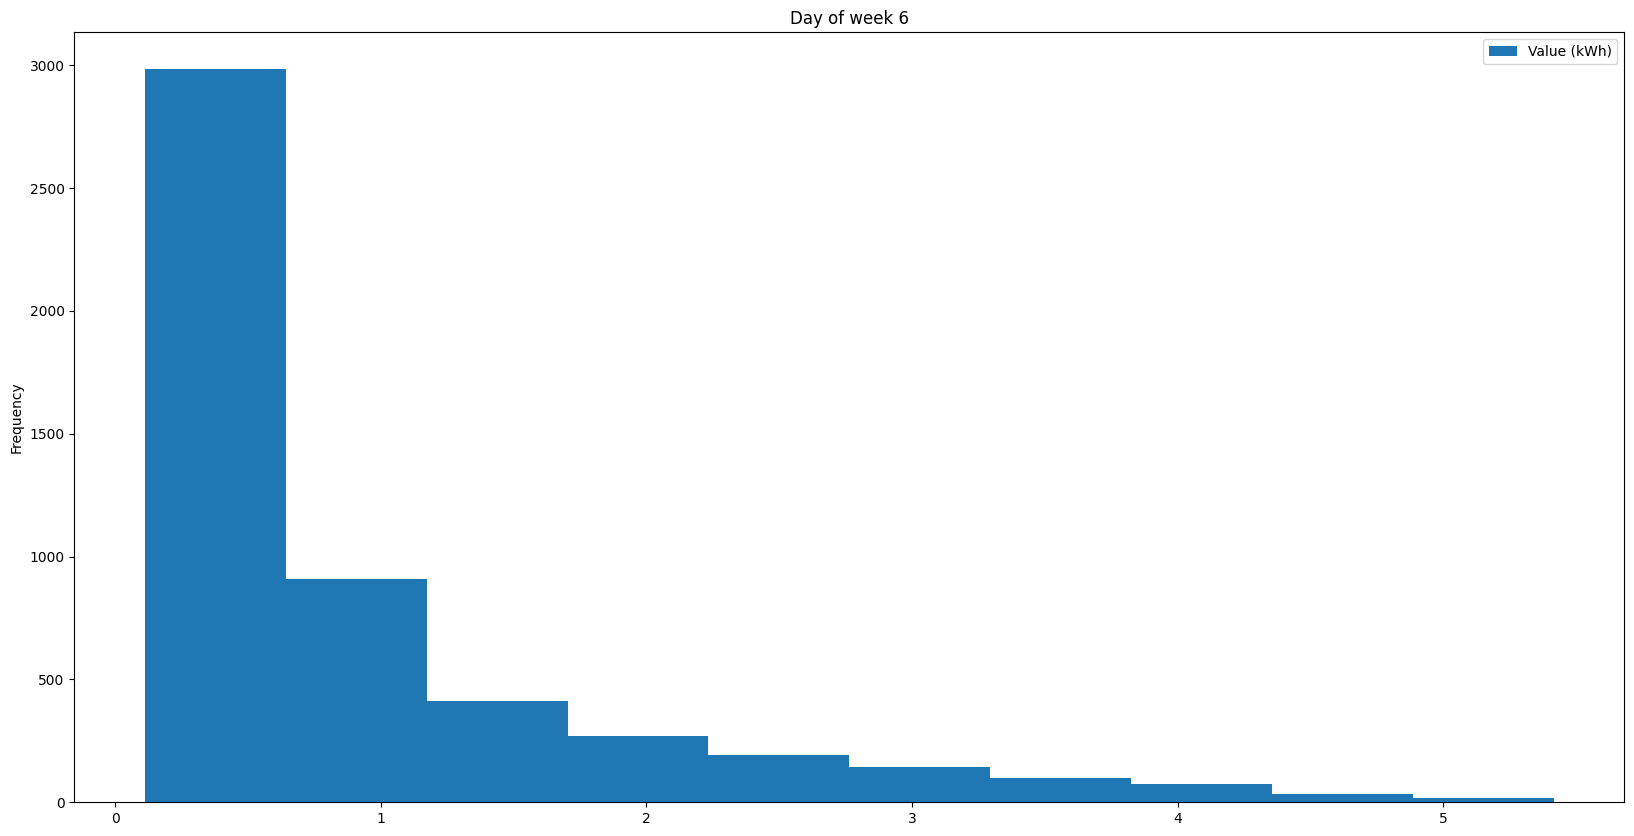

In [146]:
for i in range(0,7):
    df[df['day_of_week']==i].plot.hist(y='Value (kWh)', figsize=(20, 10), title=f'Day of week {i}')

### Day of week histograms of the power usage seem to point towards an exponential distribution 

<Axes: xlabel='StartDate'>

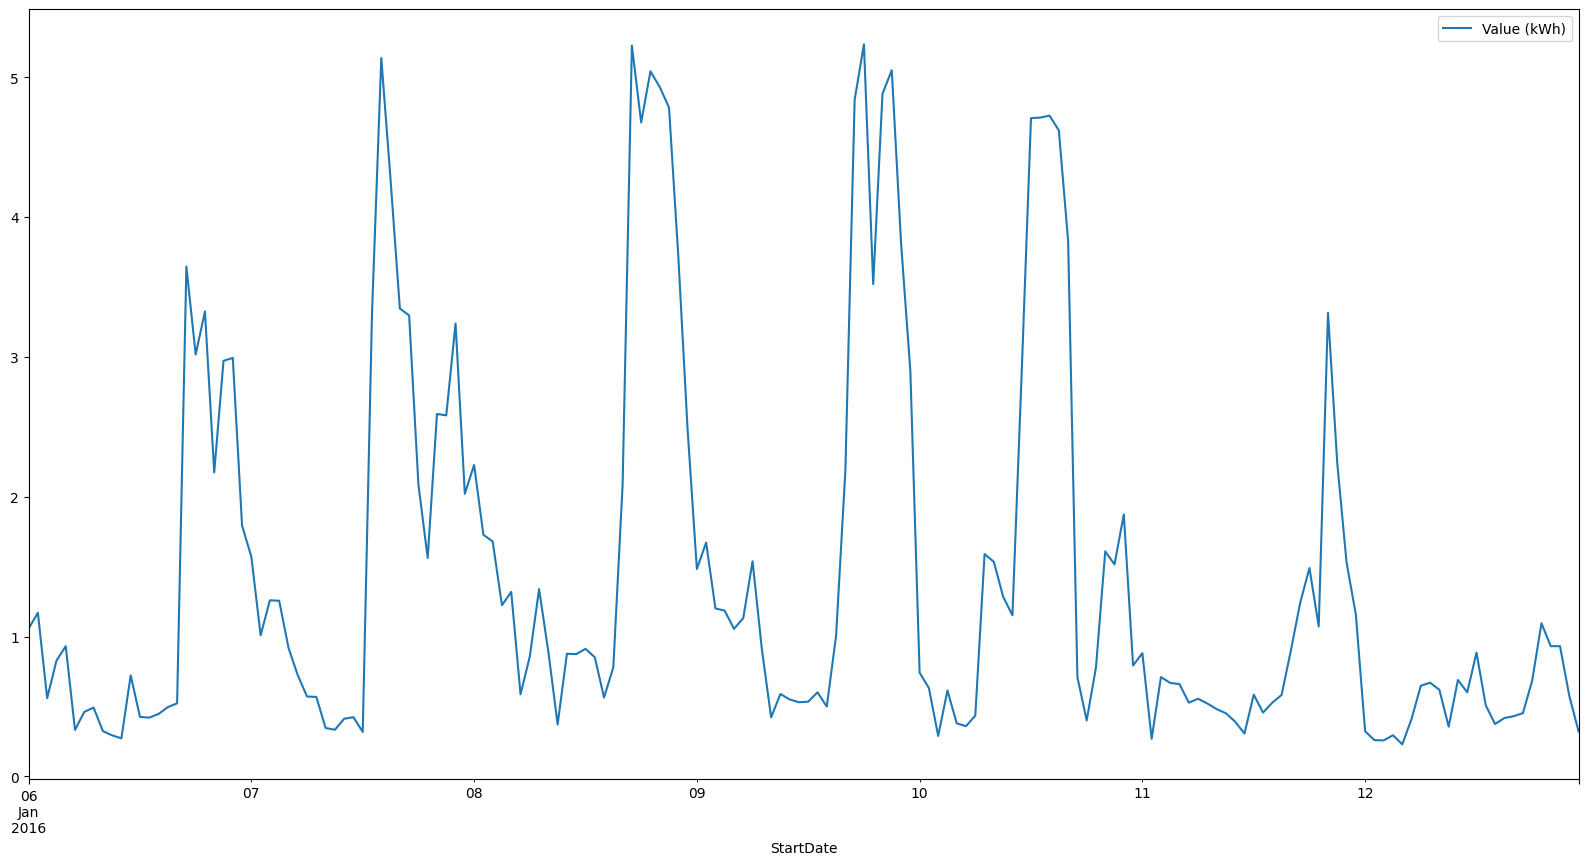

In [16]:
df2016[df2016['month']==1].plot.line(x='StartDate', y='Value (kWh)', figsize=(20, 10))

### 2016 appears to be missing days in the first 6 months and do not have full months for the remainder of the year. This would appear to be the case for end of 2020. A forecast will be generated for 2020 based on 2017 - 2019 and an anamoly detection for 2017 - 2019 will also be created.

## Forecast

In [17]:
df2 = df[df['year'].isin([2017, 2018, 2019])]
df2 = df2.sort_values(by='StartDate',ascending=True)

In [18]:
df2.groupby('year').agg('count')

,StartDate,Value (kWh),day_of_week,notes,month
year,,,,,
2017,8760,8760,8760,8760,8760
2018,8760,8760,8760,8760,8760
2019,8760,8760,8760,8760,8760


In [19]:
df2.head()

,StartDate,Value (kWh),day_of_week,notes,year,month
5136,2017-01-01 00:00:00,0.840,6,weekend,2017,1
5137,2017-01-01 01:00:00,0.731,6,weekend,2017,1
5138,2017-01-01 02:00:00,0.254,6,weekend,2017,1
5139,2017-01-01 03:00:00,0.270,6,weekend,2017,1
5140,2017-01-01 04:00:00,0.318,6,weekend,2017,1


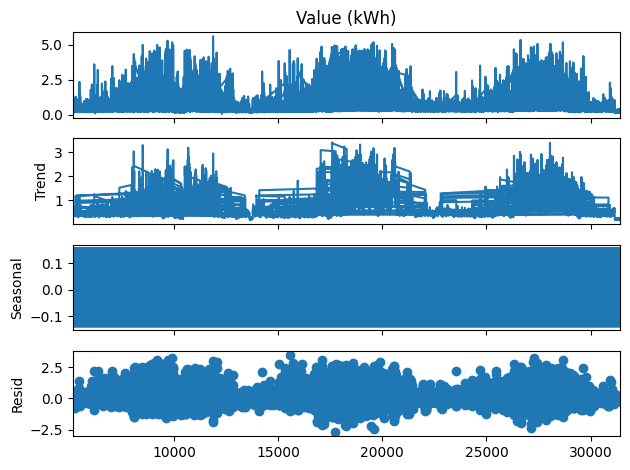

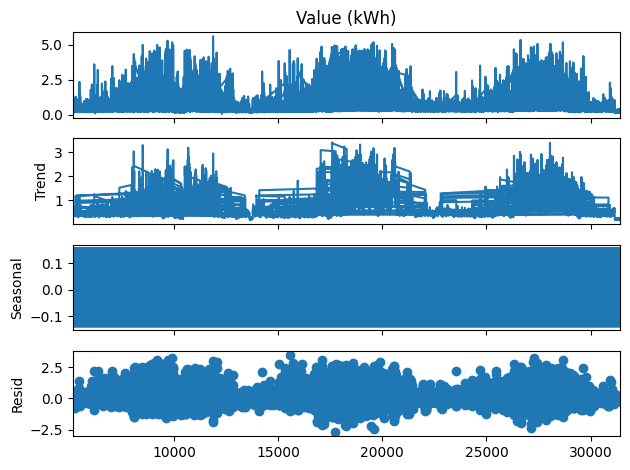

In [20]:
seasonal_decompose(df2['Value (kWh)'], model='additive', period=12).plot()

<Axes: xlabel='Date', ylabel='Value (kWh)'>

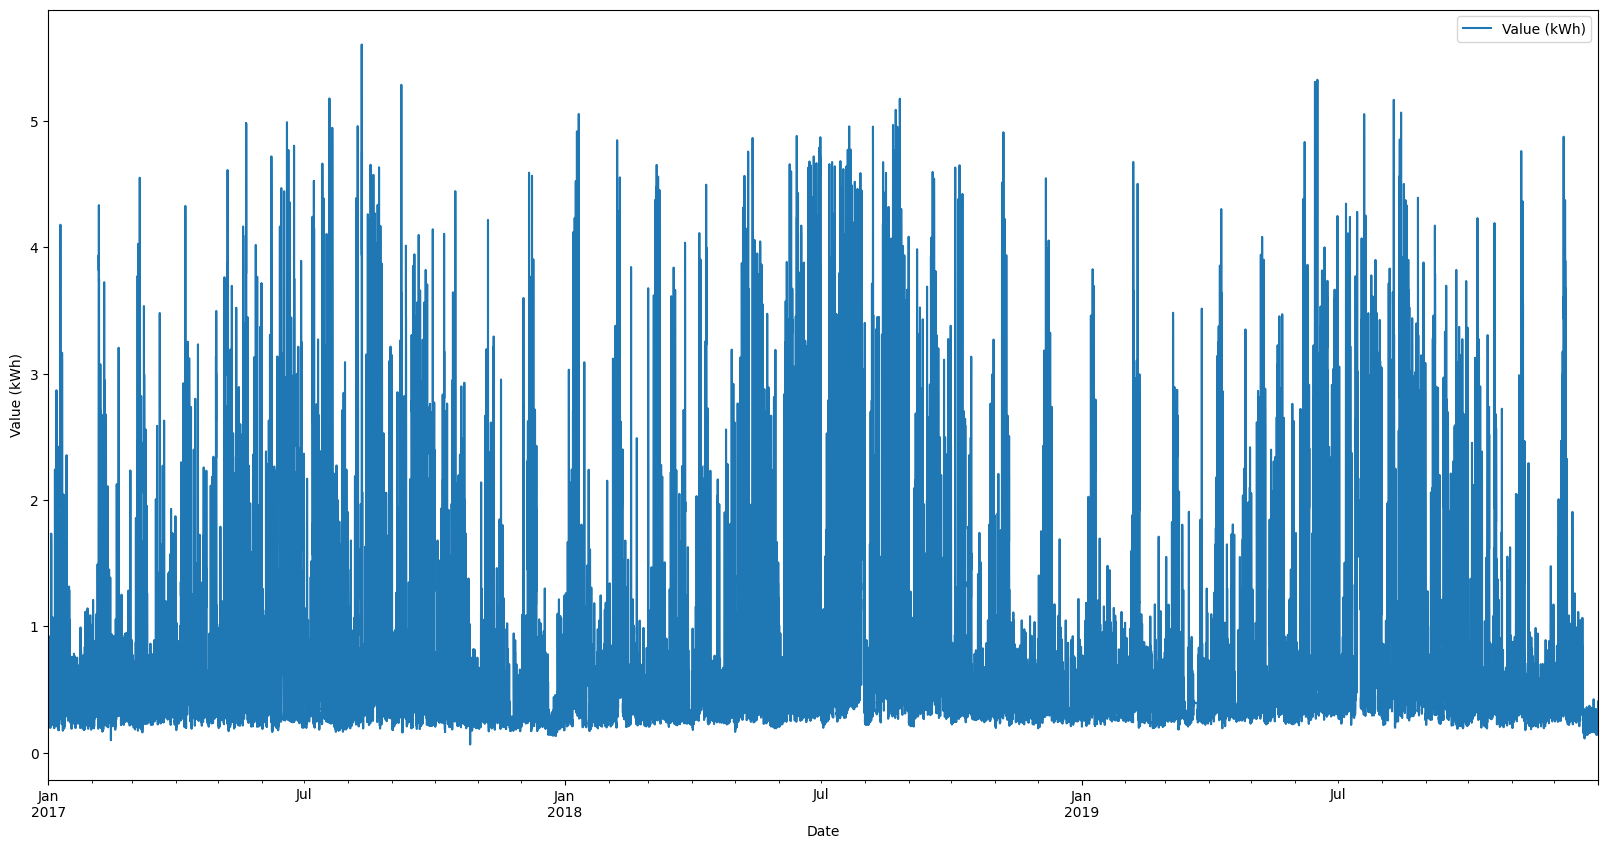

In [21]:
df2.plot.line(x='StartDate', y='Value (kWh)', figsize=(20, 10), xlabel='Date', ylabel='Value (kWh)')

<Axes: xlabel='Date', ylabel='Value (kWh)'>

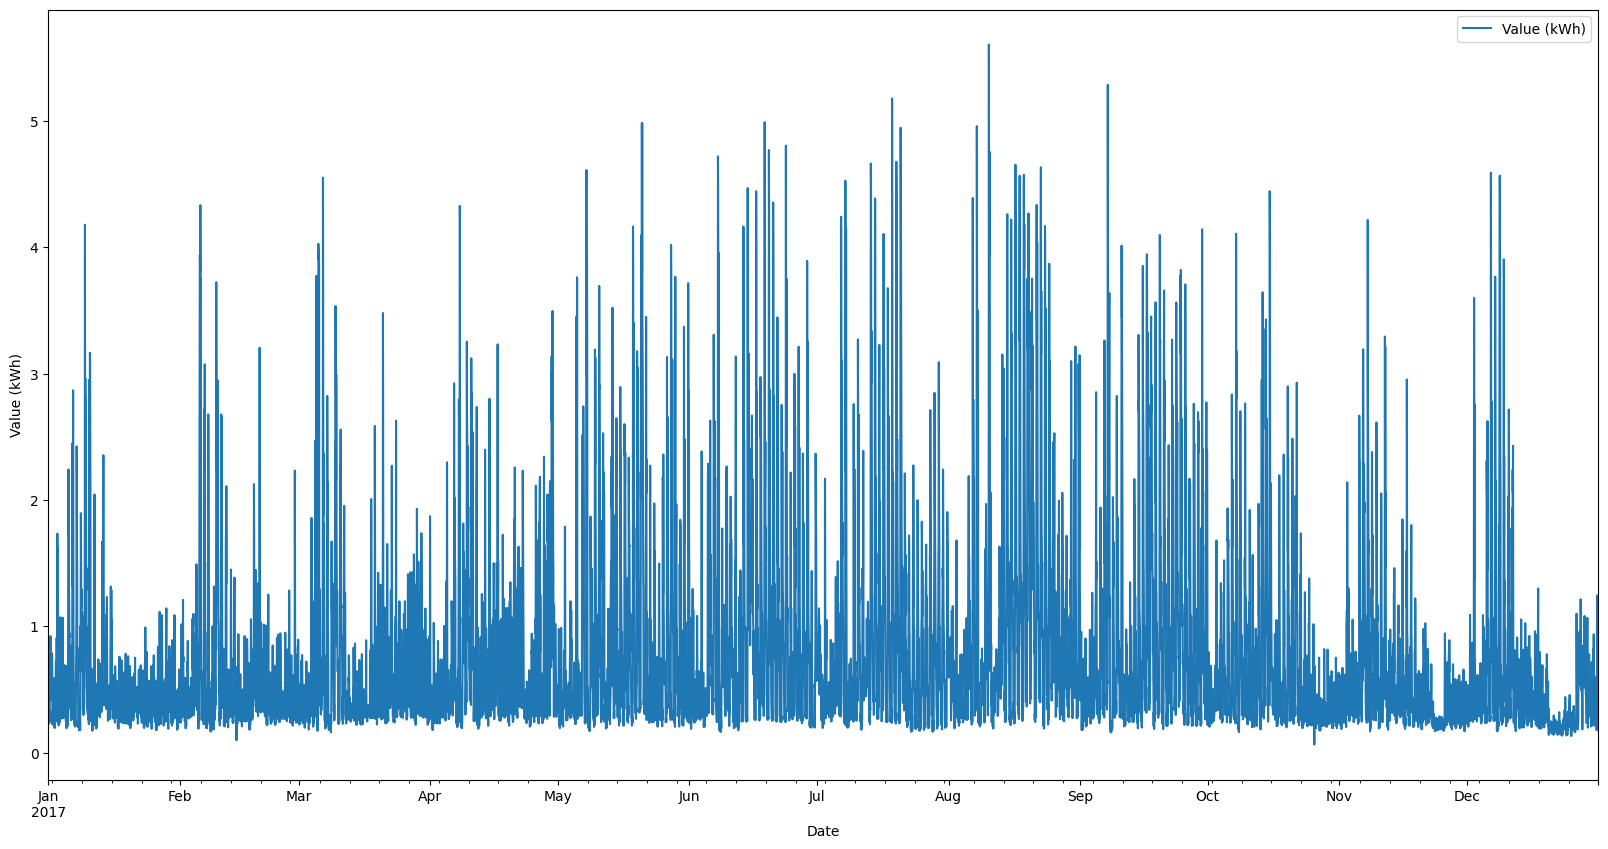

In [22]:
df2[df2['year']==2017].plot.line(x='StartDate', y='Value (kWh)', figsize=(20, 10), xlabel='Date', ylabel='Value (kWh)')

<Axes: xlabel='Date', ylabel='Value (kWh)'>

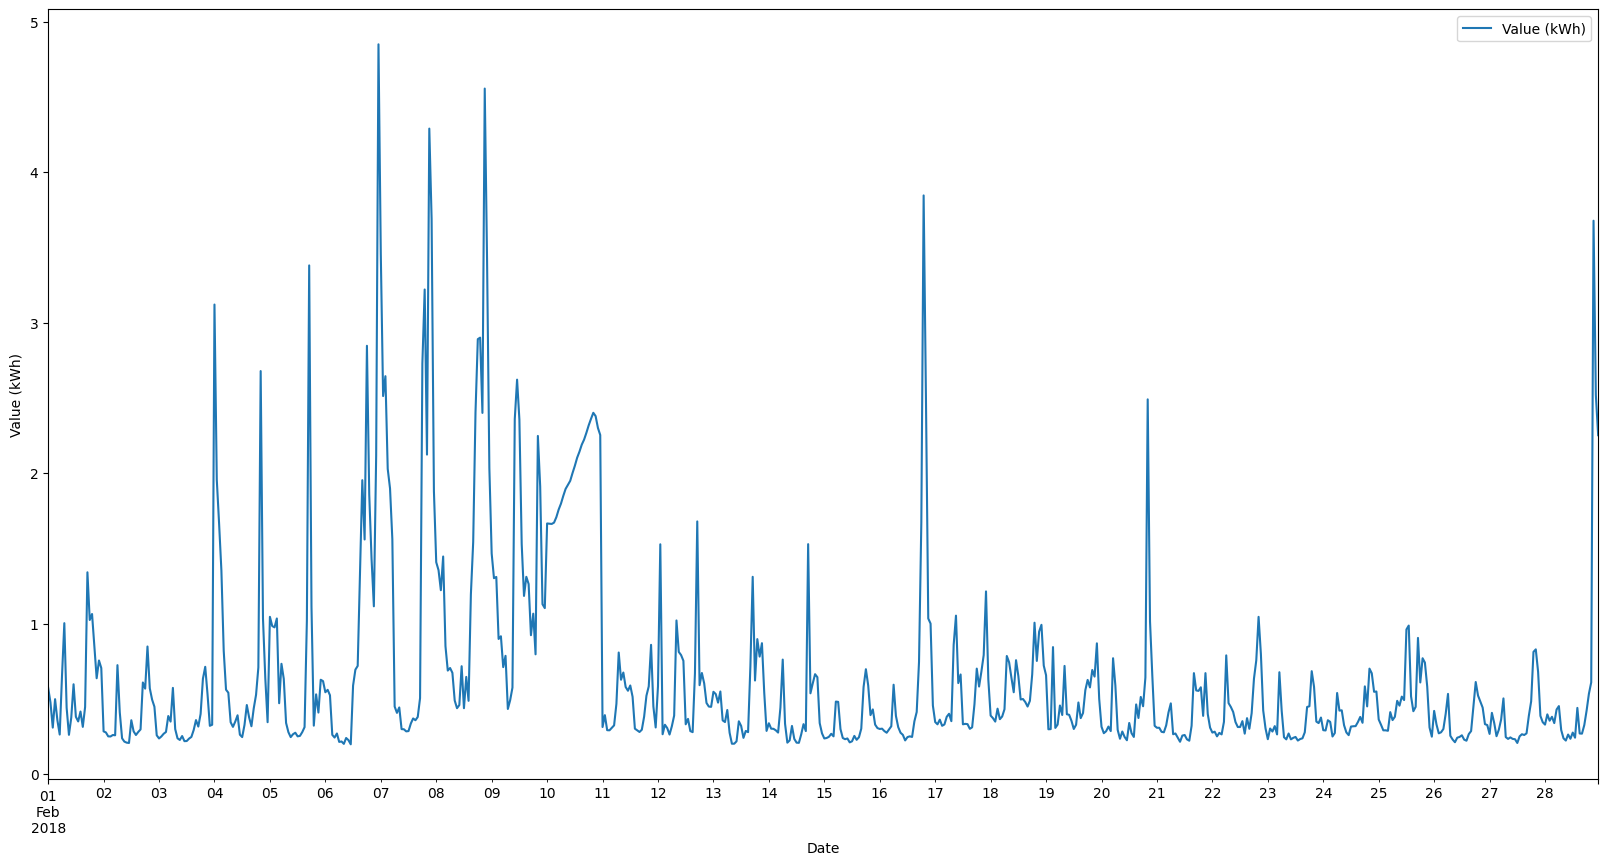

In [23]:
df2[(df2['year']==2018) & (df2['month']==2)].plot.line(x='StartDate', y='Value (kWh)', figsize=(20, 10), xlabel='Date', ylabel='Value (kWh)')

In [24]:
from statsmodels.tsa.stattools import adfuller

In [25]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
# Call the function and run the test

adf_test(df2['Value (kWh)'])

Results of Dickey-Fuller Test:
Test Statistic                -1.107772e+01
p-value                        4.389651e-20
#Lags Used                     4.900000e+01
Number of Observations Used    2.623000e+04
Critical Value (1%)           -3.430599e+00
Critical Value (5%)           -2.861650e+00
Critical Value (10%)          -2.566829e+00
dtype: float64


In [26]:
from statsmodels.tsa.stattools import kpss
kpss_result = kpss(df2['Value (kWh)'], regression='c', nlags="auto")

/var/folders/1s/_3xxr92n2m546tpmlwp5bssc0000gn/T/ipykernel_2947/1322946064.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df2['Value (kWh)'], regression='c', nlags="auto")


In [27]:
kpss_result

(0.7413425459779974,
 0.01,
 68,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### Analysis from the ADF test shows the data is stationary while the KPSS test shows the data to be non-stationary at 5% significance. Use of differencing will be used to further analyze the data.

<Axes: xlabel='StartDate'>

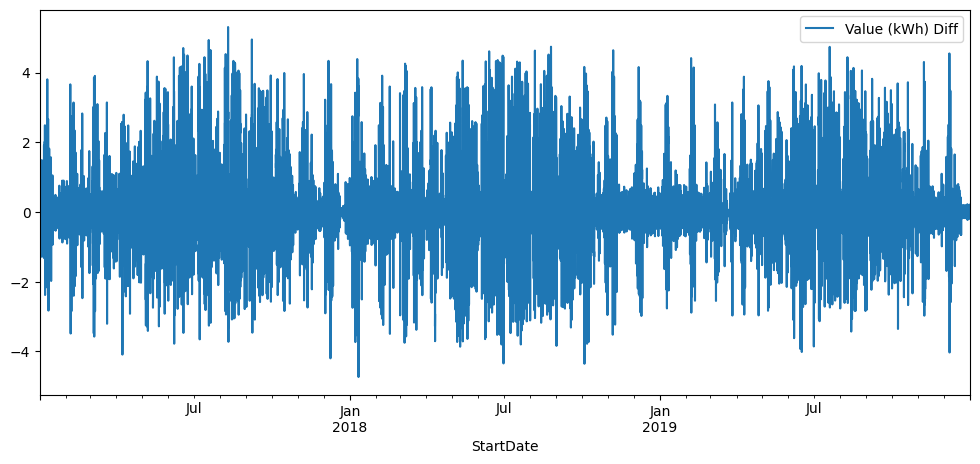

In [28]:
df2['Value (kWh) Diff'] = df2['Value (kWh)'] - df2['Value (kWh)'].shift(5)
#df2['Value (kWh) Diff'] = boxcox(df2['Value (kWh) Diff'], lmbda=0)
df2.dropna().plot(y='Value (kWh) Diff',x='StartDate',figsize=(12, 5))


In [29]:
adf_test(df2['Value (kWh) Diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                   -31.671390
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    26225.000000
Critical Value (1%)               -3.430599
Critical Value (5%)               -2.861650
Critical Value (10%)              -2.566829
dtype: float64


In [30]:
kpss_result2 = kpss(df2['Value (kWh) Diff'].dropna(), regression='c', nlags="auto")
kpss_result2

/var/folders/1s/_3xxr92n2m546tpmlwp5bssc0000gn/T/ipykernel_2947/2798207674.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result2 = kpss(df2['Value (kWh) Diff'].dropna(), regression='c', nlags="auto")


(0.0040204607425086535,
 0.1,
 137,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

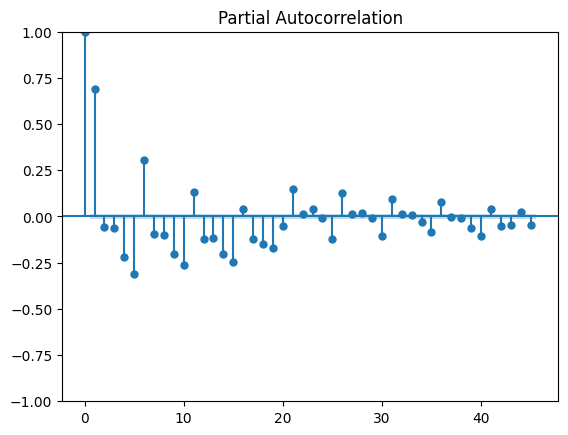

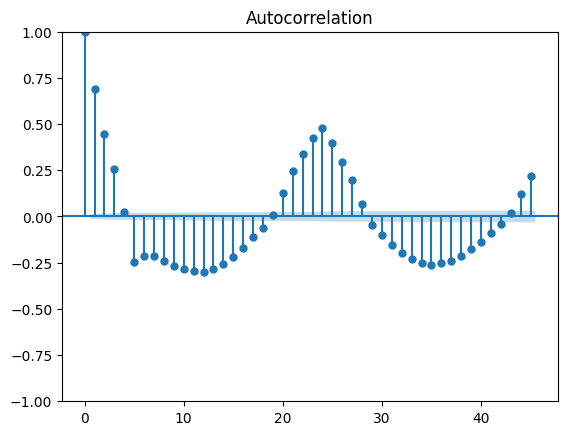

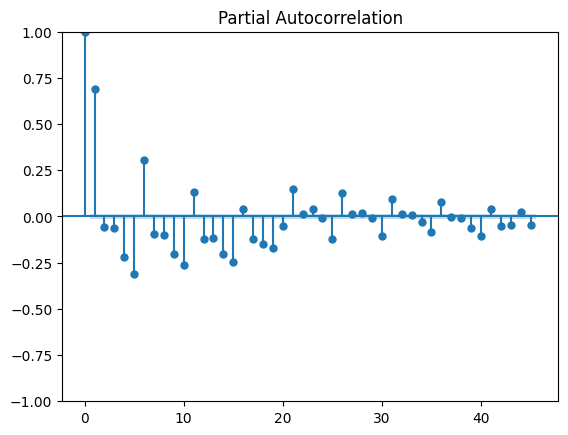

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df2['Value (kWh) Diff'].dropna())
plot_pacf(df2['Value (kWh) Diff'].dropna(),method='ywm')

### After differencing, the tests now show the data is stationary and will therefore be analzyed further as stationary data. An ARIMA model will be used to look into the forecasting the data.

In [32]:
df2 = df2.dropna()

In [33]:
ARIMA_model = ARIMA(df2['Value (kWh)'], order=(5, 1, 5))

/Users/ed/Documents/Machine Learning/Python Analysis/OtherML/ml1/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/ed/Documents/Machine Learning/Python Analysis/OtherML/ml1/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/ed/Documents/Machine Learning/Python Analysis/OtherML/ml1/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, f

In [34]:
ARIMA_model_fit = ARIMA_model.fit()

/Users/ed/Documents/Machine Learning/Python Analysis/OtherML/ml1/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ed/Documents/Machine Learning/Python Analysis/OtherML/ml1/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ed/Documents/Machine Learning/Python Analysis/OtherML/ml1/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [35]:
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Value (kWh)   No. Observations:                26275
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -18848.847
Date:                Tue, 04 Feb 2025   AIC                          37719.694
Time:                        19:46:52   BIC                          37809.634
Sample:                             0   HQIC                         37748.736
                              - 26275                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7955      7.751     -0.103      0.918     -15.988      14.397
ar.L2         -0.4006      0.544     -0.737      0.461      -1.466       0.665
ar.L3         -0.3259      2.692     -0.121      0.904      -5.602       4.950
ar.L4          0.5703      0.597      0.956      0.339      -0.599       1.740
ar.L5          0.4588      4.872      0.094      0.925      -9.091      10.008
ma.L1          0.5644      7.752      0.073      0.942     -14.629      15.758
ma.L2          0.0327      1.253      0.026      0.979      -2.423       2.489
ma.L3         -0.0299      1.141     -0.026      0.979      -2.265       2.206
ma.L4         -0.9084      1.036     -0.877      0.381      -2.939       1.123
ma.L5         -0.5939      6.314     -0.094      0.925     -12.969      11.781
sigma2         0.2456      0.001    299.118      0.000       0.244       0.247
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):            209719.72
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             2.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
df24 = df2.iloc[::24]

/var/folders/1s/_3xxr92n2m546tpmlwp5bssc0000gn/T/ipykernel_2947/11762413.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df24['Value (kWh) Diff'] = df24['Value (kWh)'] - df24['Value (kWh)'].shift(24)


<Axes: xlabel='StartDate'>

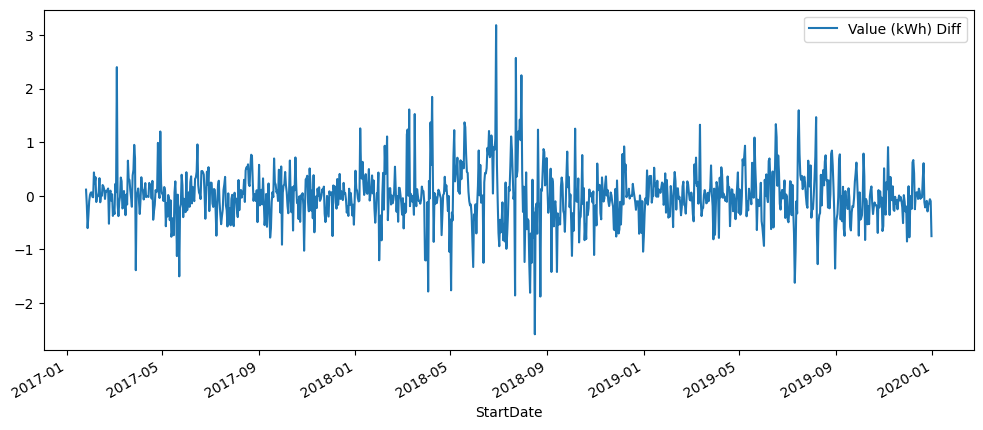

In [79]:
df24['Value (kWh) Diff'] = df24['Value (kWh)'] - df24['Value (kWh)'].shift(24)
df24.dropna().plot(y='Value (kWh) Diff',x='StartDate',figsize=(12, 5))

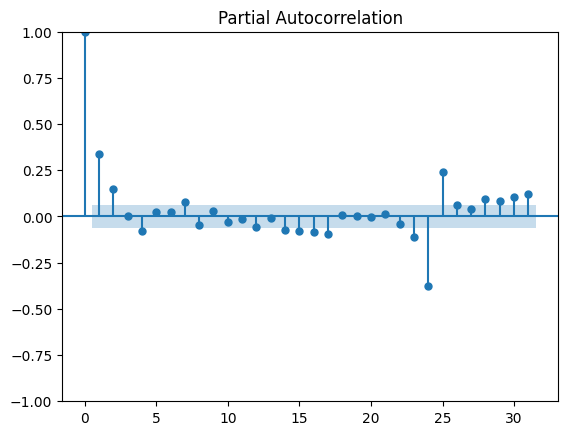

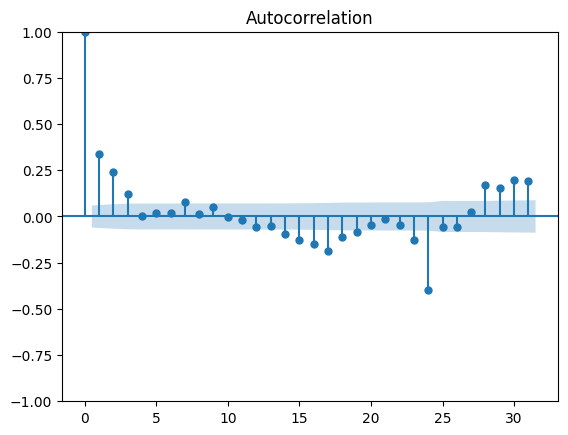

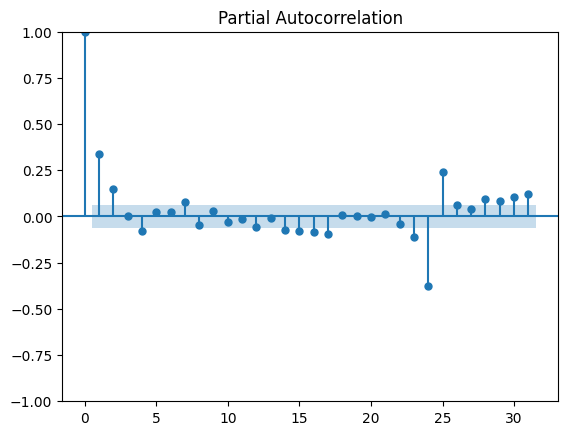

In [81]:
plot_acf(df24['Value (kWh) Diff'].dropna())
plot_pacf(df24['Value (kWh) Diff'].dropna(),method='ywm')

In [82]:
adf_test(df24['Value (kWh) Diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -9.239500e+00
p-value                        1.596712e-15
#Lags Used                     2.200000e+01
Number of Observations Used    1.048000e+03
Critical Value (1%)           -3.436605e+00
Critical Value (5%)           -2.864302e+00
Critical Value (10%)          -2.568240e+00
dtype: float64


In [83]:
kpss_result2 = kpss(df24['Value (kWh) Diff'].dropna(), regression='c', nlags="auto")
kpss_result2

/var/folders/1s/_3xxr92n2m546tpmlwp5bssc0000gn/T/ipykernel_2947/1804603821.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result2 = kpss(df24['Value (kWh) Diff'].dropna(), regression='c', nlags="auto")


(0.07345078745032399,
 0.1,
 11,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [135]:
from statsmodels.tsa.statespace.varmax import VARMAX

ARIMA_model = ARIMA(df24['Value (kWh)'], order=(24,1,24)).fit()


/Users/ed/Documents/Machine Learning/Python Analysis/OtherML/ml1/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/ed/Documents/Machine Learning/Python Analysis/OtherML/ml1/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/ed/Documents/Machine Learning/Python Analysis/OtherML/ml1/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, f

In [136]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Value (kWh)   No. Observations:                 1095
Model:               ARIMA(24, 1, 24)   Log Likelihood                -327.294
Date:                Tue, 04 Feb 2025   AIC                            752.587
Time:                        20:24:51   BIC                            997.469
Sample:                             0   HQIC                           845.253
                               - 1095                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1897      0.411     -0.462      0.644      -0.994       0.615
ar.L2         -0.4513      0.329     -1.371      0.170      -1.097       0.194
ar.L3         -0.4342      0.439     -0.990      0.322      -1.294       0.425
ar.L4         -0.0695      0.407     -0.171      0.864      -0.867       0.728
ar.L5         -0.3675      0.343     -1.070      0.285      -1.041       0.306
ar.L6         -0.0584      0.399     -0.146      0.884      -0.841       0.724
ar.L7          0.2460      0.304      0.811      0.418      -0.349       0.841
ar.L8          0.1532      0.180      0.852      0.394      -0.199       0.506
ar.L9          0.2167      0.157      1.384      0.166      -0.090       0.524
ar.L10         0.3585      0.156      2.304      0.021       0.054       0.663
ar.L11        -0.0347      0.238     -0.146      0.884      -0.501       0.432
ar.L12         0.2009      0.176      1.142      0.254      -0.144       0.546
ar.L13        -0.0243      0.229     -0.106      0.915      -0.473       0.424
ar.L14        -0.2591      0.163     -1.586      0.113      -0.579       0.061
ar.L15        -0.3173      0.158     -2.011      0.044      -0.627      -0.008
ar.L16        -0.2322      0.216     -1.074      0.283      -0.656       0.192
ar.L17        -0.5162      0.254     -2.031      0.042      -1.014      -0.018
ar.L18        -0.1258      0.345     -0.365      0.715      -0.801       0.550
ar.L19        -0.4006      0.282     -1.421      0.155      -0.953       0.152
ar.L20        -0.3009      0.355     -0.848      0.397      -0.997       0.395
ar.L21        -0.0085      0.371     -0.023      0.982      -0.736       0.719
ar.L22        -0.3063      0.230     -1.331      0.183      -0.757       0.145
ar.L23         0.2867      0.277      1.036      0.300      -0.256       0.829
ar.L24         0.1411      0.056      2.519      0.012       0.031       0.251
ma.L1         -0.5448      0.411     -1.325      0.185      -1.351       0.261
ma.L2          0.2468      0.206      1.198      0.231      -0.157       0.651
ma.L3          0.0037      0.264      0.014      0.989      -0.514       0.521
ma.L4         -0.3663      0.206     -1.778      0.075      -0.770       0.037
ma.L5          0.2481      0.216      1.148      0.251      -0.176       0.672
ma.L6         -0.2796      0.236     -1.187      0.235      -0.741       0.182
ma.L7         -0.2712      0.272     -0.997      0.319      -0.805       0.262
ma.L8         -0.0749      0.274     -0.274      0.784      -0.611       0.461
ma.L9         -0.0613      0.284     -0.216      0.829      -0.618       0.496
ma.L10        -0.1948      0.242     -0.805      0.421      -0.669       0.280
ma.L11         0.2903      0.267      1.089      0.276      -0.232       0.813
ma.L12        -0.1826      0.237     -0.770      0.441      -0.647       0.282
ma.L13         0.1803      0.253      0.713      0.476      -0.315       0.676
ma.L14         0.2182      0.238      0.917      0.359      -0.248       0.684
ma

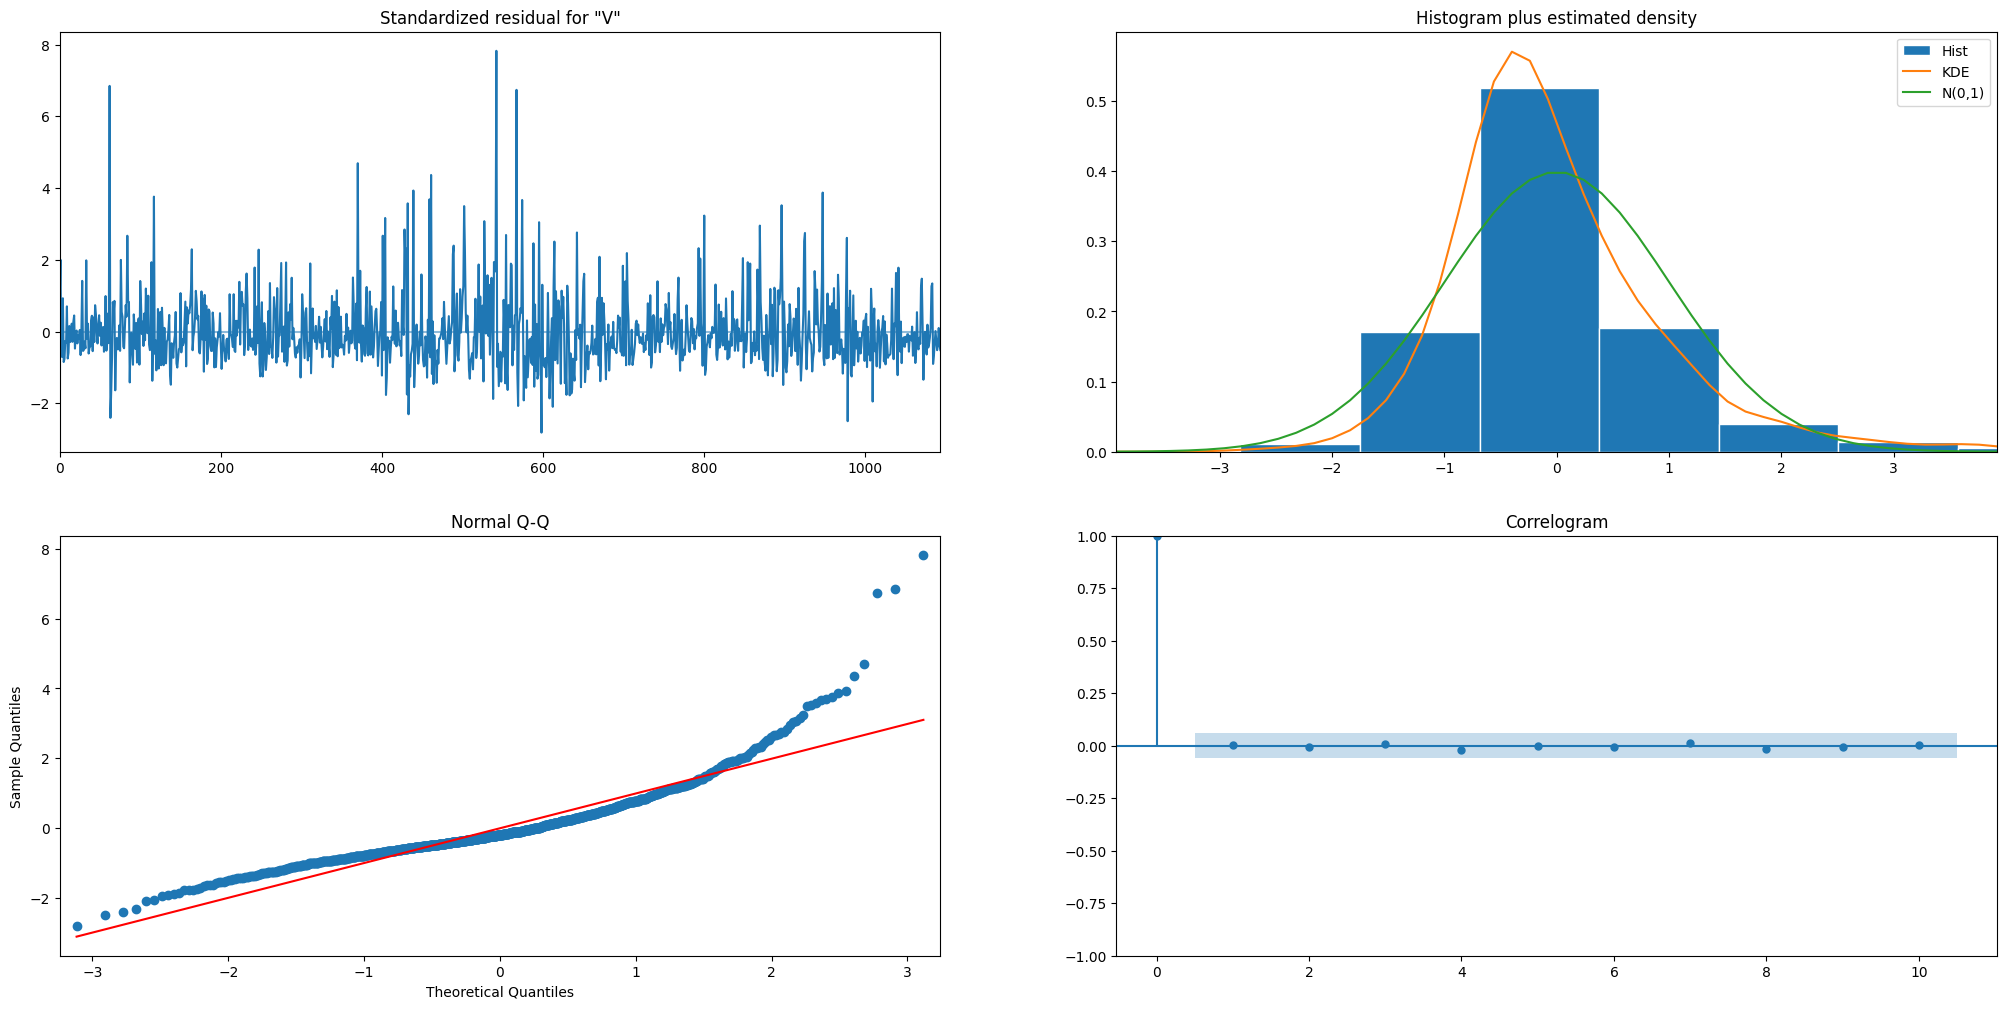

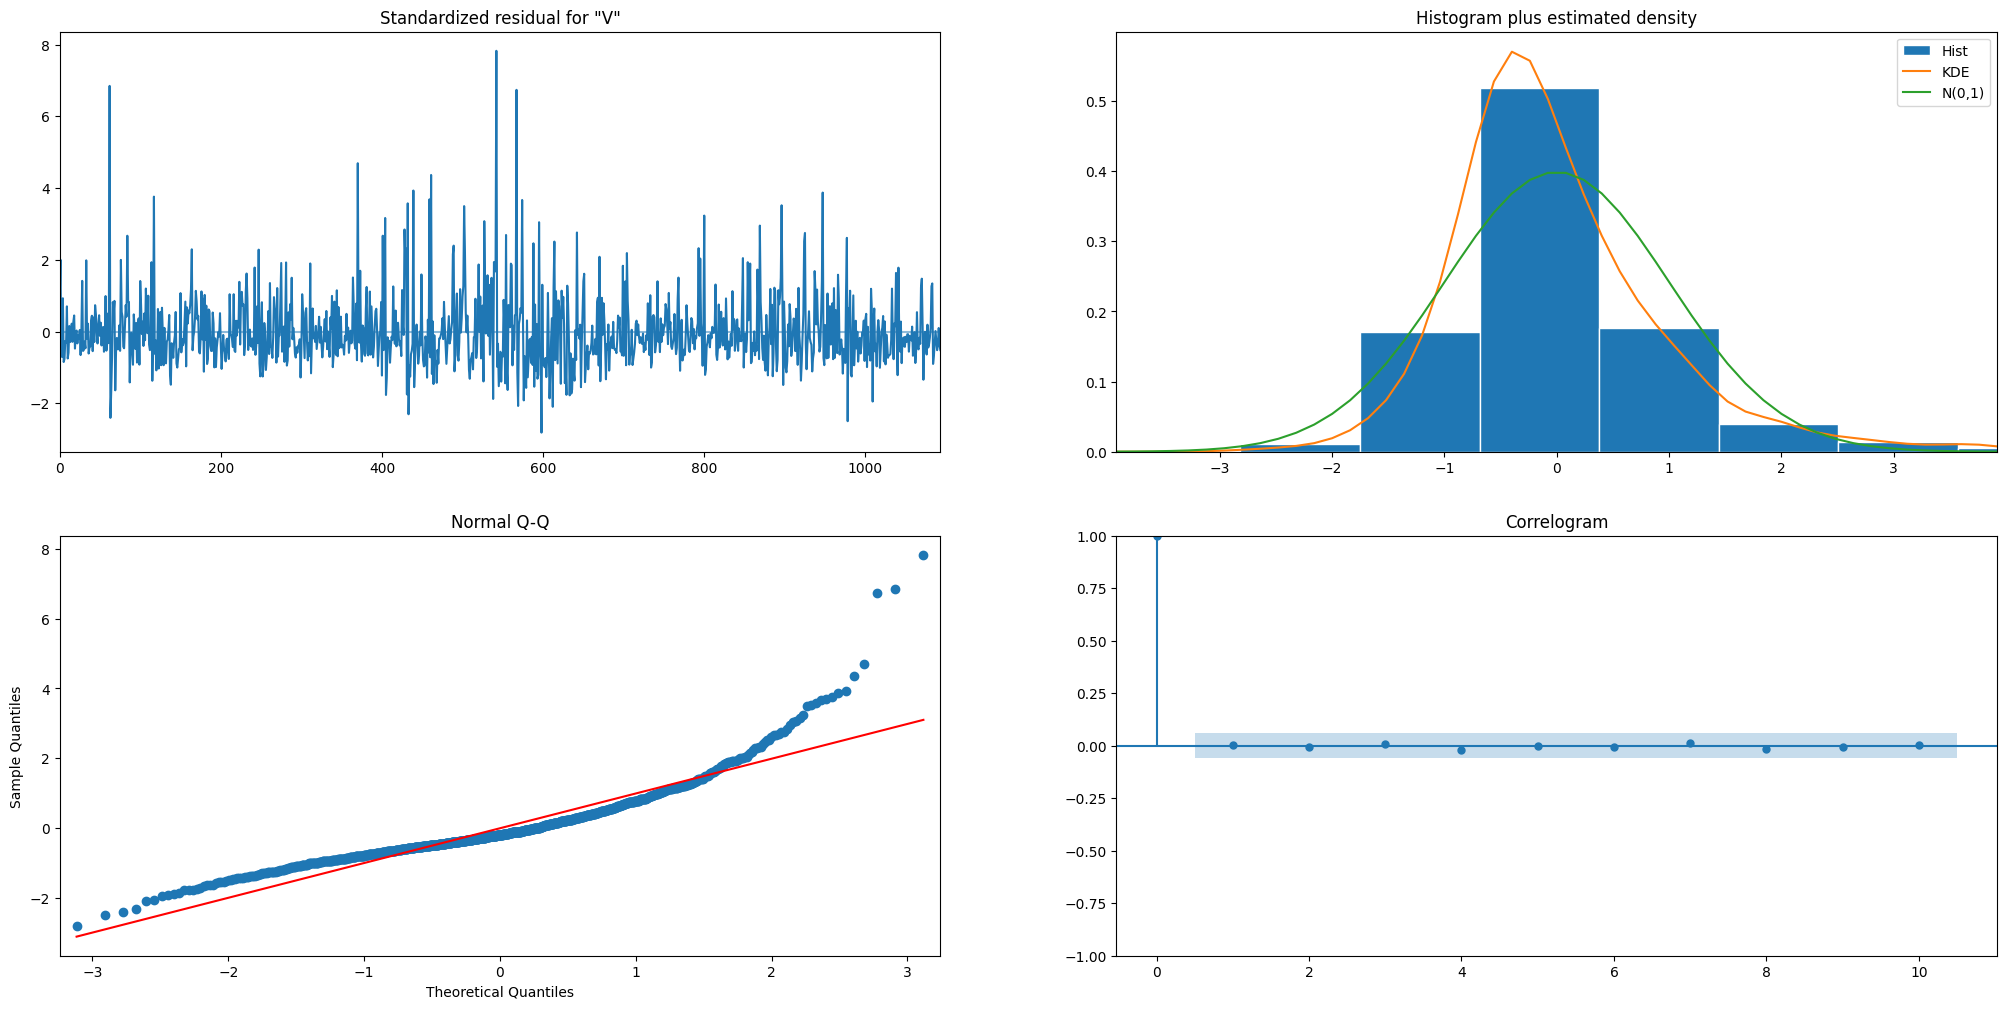

In [137]:
ARIMA_model.plot_diagnostics(figsize=(25, 12))

In [138]:
pred = ARIMA_model.forecast(steps=366)

/Users/ed/Documents/Machine Learning/Python Analysis/OtherML/ml1/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ed/Documents/Machine Learning/Python Analysis/OtherML/ml1/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [139]:
date_range = pd.date_range(start='2020-01-01', end='2020-12-31', freq='D')
pred = pd.DataFrame(pred)
pred['StartDate'] = date_range

In [140]:
pred.columns = ['Value (kWh)', 'StartDate']
pred.head()

,Value (kWh),StartDate
1095,0.270219,2020-01-01
1096,0.277519,2020-01-02
1097,0.226985,2020-01-03
1098,0.229592,2020-01-04
1099,0.374685,2020-01-05


In [141]:
pred['Value (kWh)'] = pred['Value (kWh)']

/var/folders/1s/_3xxr92n2m546tpmlwp5bssc0000gn/T/ipykernel_2947/3473198007.py:2: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(pred['StartDate'], pred['Value (kWh) Diff'], color='red')


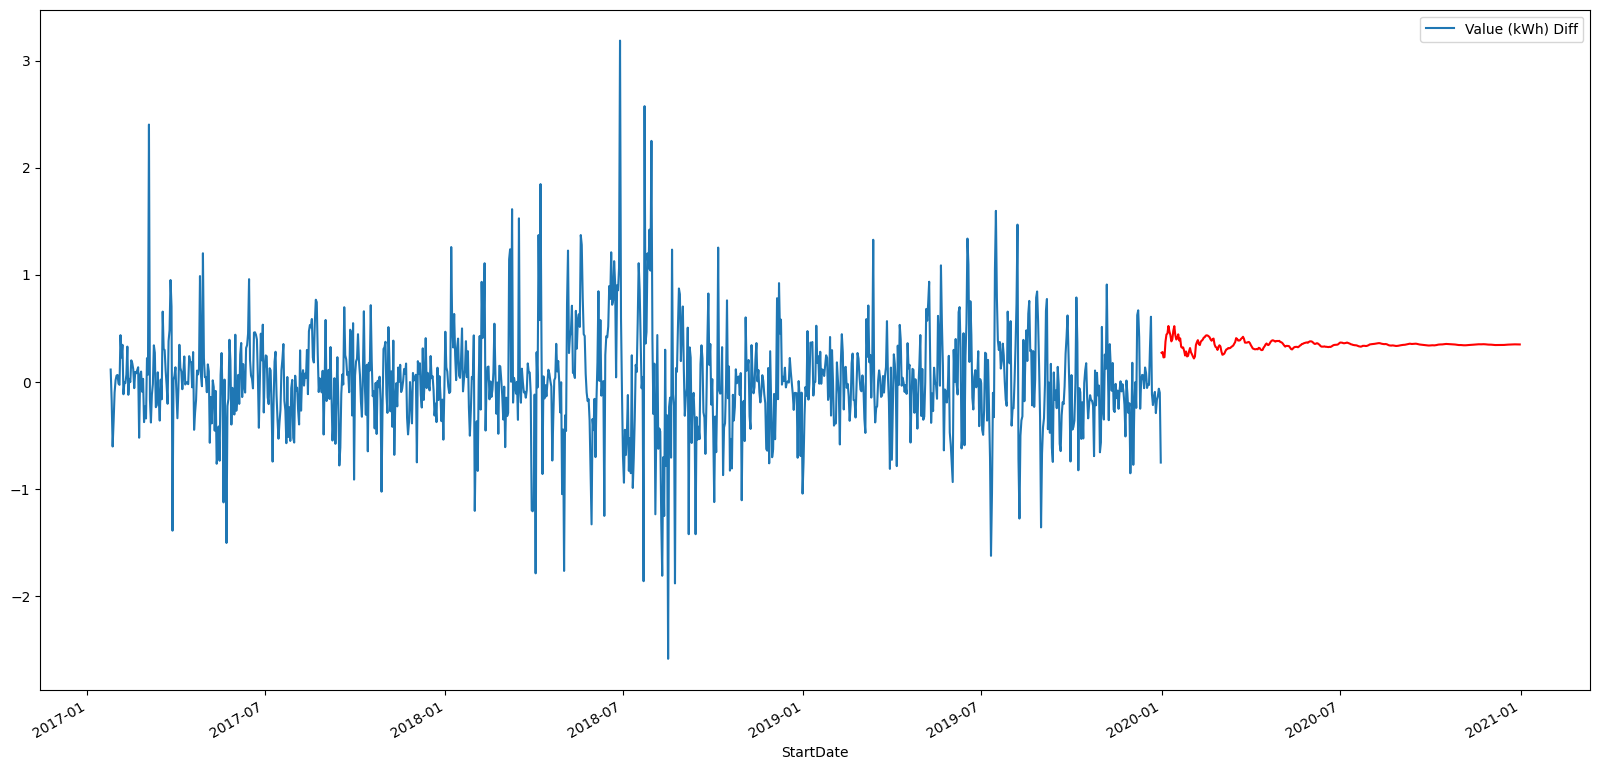

In [ ]:
df24.plot.line(x='StartDate', y='Value (kWh) Diff',figsize=(20, 10))
plt.plot(pred['StartDate'], pred['Value (kWh)'], color='red')

### EEMD in combonation with an Isolation Forest will be used to see if the data can find anomalies.

In [52]:
from PyEMD import EEMD
eemd = EEMD()

In [53]:
imfs = eemd.eemd(df['Value (kWh)'].values)

In [54]:
imfs.shape

(15, 35952)

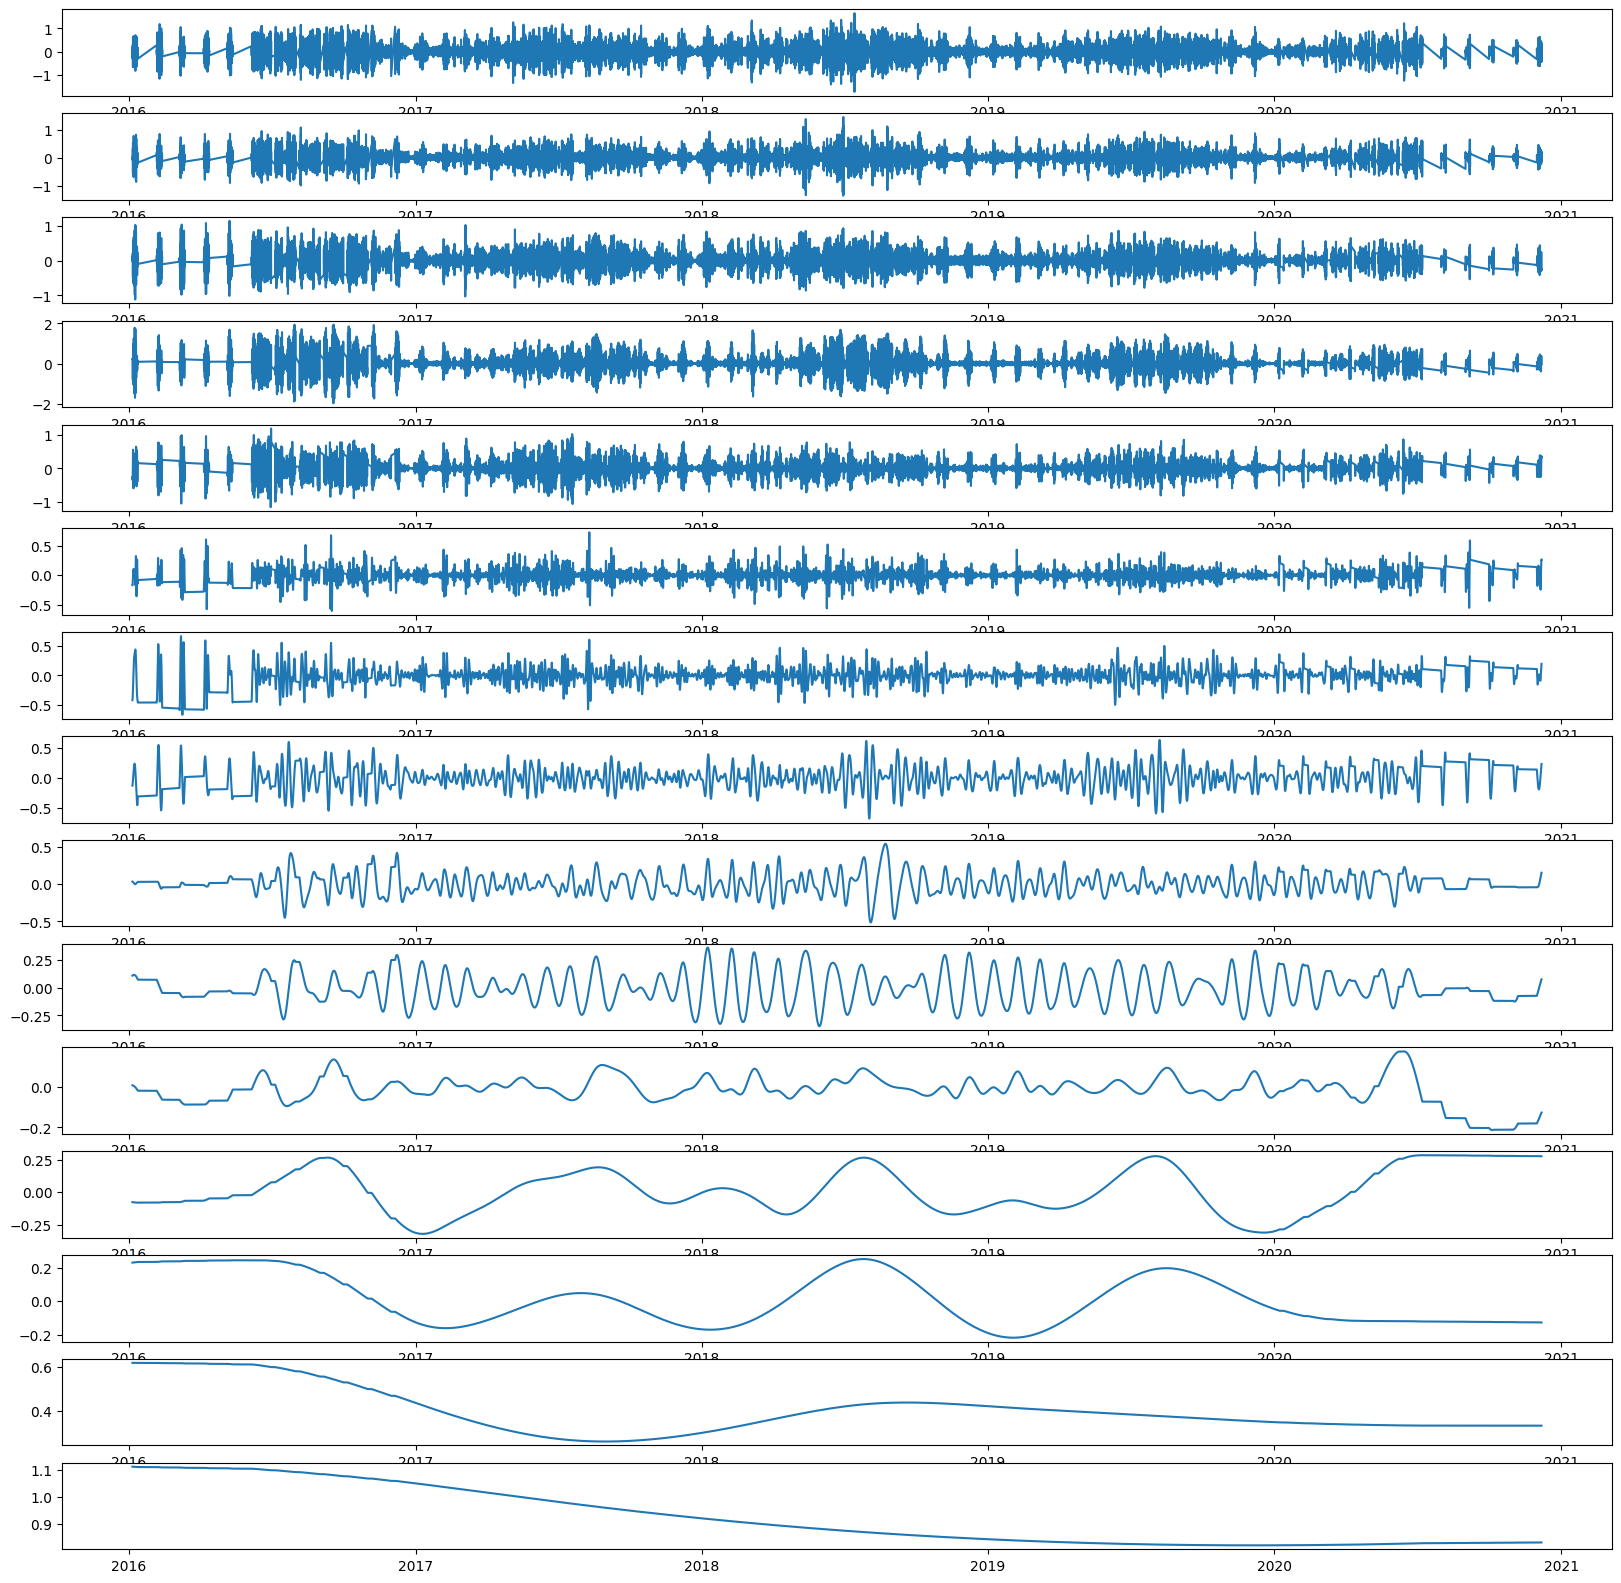

In [57]:
fig, ax = plt.subplots(imfs.shape[0],1,figsize=(20, 20))
for i in range(imfs.shape[0]):
    ax[i].plot(df['StartDate'], imfs[i])

In [58]:
from sklearn.ensemble import IsolationForest

In [155]:
isof = IsolationForest(contamination=0.01, n_estimators=500, n_jobs=-1)

In [156]:
isof.fit(imfs[4].reshape(-1, 1))

IsolationForest(contamination=0.01, n_estimators=500, n_jobs=-1)

In [157]:
#imfs2 = eemd.eemd(df2016['Value (kWh)'].values)
pred = isof.predict(imfs[4].reshape(-1, 1))
preds = pd.DataFrame(pred)
predidx = preds[preds[0] == -1].index

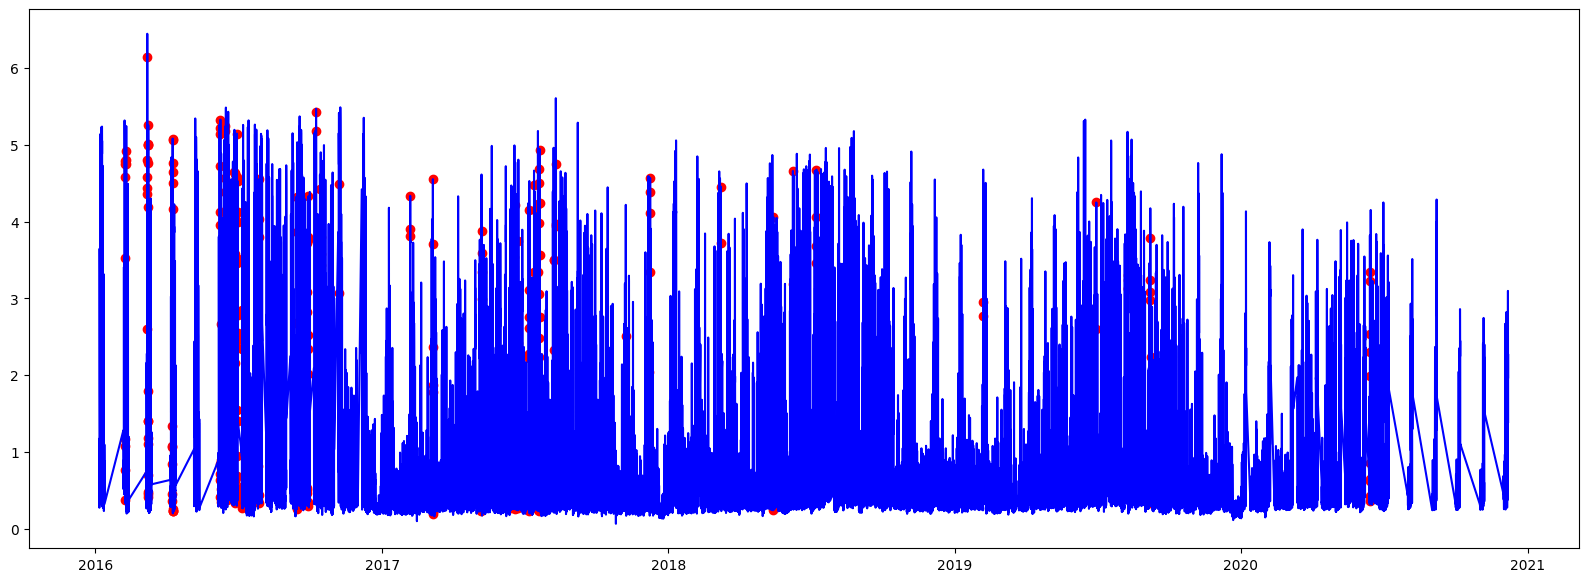

In [158]:
plt.figure(figsize=(20, 7))
plt.plot(df['StartDate'], df['Value (kWh)'], color='blue')
plt.scatter(df.iloc[predidx]['StartDate'], df.iloc[predidx]['Value (kWh)'], color='red')
